### import libarys

In [1]:
import os
import pandas as pd


### Top 10 Coins nach Marketcap

In [2]:
import requests
import pandas as pd

def fetch_top_10_coins():
    url = "https://api.coingecko.com/api/v3/coins/markets"
    params = {
        "vs_currency": "usd",
        "order": "market_cap_desc",
        "per_page": 10,
        "page": 1,
        "sparkline": False
    }
    response = requests.get(url, params=params)
    if response.status_code == 200:
        data = response.json()
        coins = [{"Symbol": coin["symbol"].upper(), "Name": coin["name"], "Market Cap": coin["market_cap"]} for coin in data]
        return pd.DataFrame(coins)
    else:
        print("Fehler beim Abrufen der Daten:", response.status_code)
        return None

# Abrufen der Top-10-Coins
top_10_coins = fetch_top_10_coins()
print(top_10_coins)


  Symbol               Name     Market Cap
0    BTC            Bitcoin  1910405748219
1    ETH           Ethereum   398049450832
2   USDT             Tether   132365561897
3    SOL             Solana   116428703391
4    BNB                BNB    94529375639
5    XRP                XRP    75554935482
6   DOGE           Dogecoin    59992524902
7   USDC               USDC    38912336085
8    ADA            Cardano    34535940342
9  STETH  Lido Staked Ether    32309833442


### Historische crypto daten

In [3]:
import pandas as pd
import requests
from datetime import datetime, timedelta

def fetch_historical_data_complete(symbol, interval="15m", days=180):
    base_url = "https://api.binance.com/api/v3/klines"
    end_time = int(datetime.now().timestamp() * 1000)  # Aktuelle Zeit in ms
    start_time = int((datetime.now() - timedelta(days=days)).timestamp() * 1000)  # Startzeit in ms

    all_data = []  # Hier speichern wir alle Daten
    while start_time < end_time:
        params = {
            "symbol": symbol.upper(),
            "interval": interval,
            "startTime": start_time,
            "endTime": end_time,
            "limit": 1000,  # Binance-Limit
        }
        response = requests.get(base_url, params=params)
        if response.status_code == 200:
            data = response.json()
            if not data:
                break  # Wenn keine Daten mehr vorhanden sind, beenden
            all_data.extend(data)  # Daten hinzufügen
            start_time = data[-1][6]  # Nächste Startzeit auf Basis der letzten Close Time
        else:
            print(f"Fehler beim Abrufen der Daten für {symbol}: {response.status_code}")
            break

    # Daten in DataFrame umwandeln
    df = pd.DataFrame(all_data, columns=[
        "Open Time", "Open", "High", "Low", "Close", "Volume",
        "Close Time", "Quote Asset Volume", "Number of Trades",
        "Taker Buy Base Asset Volume", "Taker Buy Quote Asset Volume", "Ignore"
    ])
    df["Open Time"] = pd.to_datetime(df["Open Time"], unit="ms")
    df["Close Time"] = pd.to_datetime(df["Close Time"], unit="ms")

    # Wichtige Spalten auswählen und neu sortieren
    df = df[["Open Time", "Open", "Close", "High", "Low"]]
    df["Open/Close %"] = ((df["Close"].astype(float) - df["Open"].astype(float)) / df["Open"].astype(float)) * 100
    return df.sort_values(by="Open Time", ascending=False)

# Beispiel: Daten für BTCUSDT abrufen
btc_data = fetch_historical_data_complete("BTCUSDT", interval="15m", days=180)
print(btc_data.head())


                Open Time            Open           Close            High  \
17283 2024-11-24 15:30:00  96643.99000000  96352.54000000  96720.24000000   
17282 2024-11-24 15:15:00  96940.69000000  96643.99000000  96940.69000000   
17281 2024-11-24 15:00:00  97029.96000000  96940.70000000  97091.31000000   
17280 2024-11-24 14:45:00  96891.44000000  97029.95000000  97108.67000000   
17279 2024-11-24 14:30:00  96608.96000000  96891.44000000  97130.24000000   

                  Low  Open/Close %  
17283  96150.00000000     -0.301571  
17282  96466.48000000     -0.306063  
17281  96729.50000000     -0.091992  
17280  96797.27000000      0.142954  
17279  96577.52000000      0.292395  


### Schleife

In [4]:
# Top-10 Coins Liste (ersetzt durch deine bereits abgerufenen Symbole)
top_10_coins = ["BTCUSDT", "ETHUSDT", "BNBUSDT", "XRPUSDT", "ADAUSDT", "DOGEUSDT", "SOLUSDT", "MATICUSDT", "DOTUSDT", "LTCUSDT"]

# Daten für alle Coins abrufen und kombinieren
all_data = []
for symbol in top_10_coins:
    print(f"Abrufen der Daten für {symbol}...")
    coin_data = fetch_historical_data_complete(symbol, interval="15m", days=180)
    coin_data["Symbol"] = symbol  # Coin-Symbol hinzufügen
    all_data.append(coin_data)

# Alle Daten zusammenführen
final_data = pd.concat(all_data, ignore_index=True)

# Sortieren nach Datum (Neu nach Alt)
final_data.sort_values(by=["Open Time"], ascending=False, inplace=True)

# In CSV speichern
final_data.to_csv("crypto_complete_data.csv", index=False)
print("Daten erfolgreich gespeichert in 'crypto_complete_data.csv'")


Abrufen der Daten für BTCUSDT...
Abrufen der Daten für ETHUSDT...
Abrufen der Daten für BNBUSDT...
Abrufen der Daten für XRPUSDT...
Abrufen der Daten für ADAUSDT...
Abrufen der Daten für DOGEUSDT...
Abrufen der Daten für SOLUSDT...
Abrufen der Daten für MATICUSDT...
Abrufen der Daten für DOTUSDT...
Abrufen der Daten für LTCUSDT...
Daten erfolgreich gespeichert in 'crypto_complete_data.csv'


### Zusammenführung

In [5]:
# Schritt 1: Top-10-Coins abrufen
top_10_coins = fetch_top_10_coins()
print("Top 10 Coins nach Marktkapitalisierung:")
print(top_10_coins)

# Schritt 2: Historische Daten für jeden Coin abrufen
for symbol in top_10_coins["Symbol"]:
    print(f"Abrufen der historischen Daten für {symbol}...")
    historical_data = fetch_historical_data_complete(symbol + "USDT", interval="15m", days=180)
    if historical_data is not None:
        print(historical_data.head())
    else:
        print(f"Keine Daten für {symbol}.")


Top 10 Coins nach Marktkapitalisierung:
  Symbol               Name     Market Cap
0    BTC            Bitcoin  1910405748219
1    ETH           Ethereum   398049450832
2   USDT             Tether   132365561897
3    SOL             Solana   116428703391
4    BNB                BNB    94529375639
5    XRP                XRP    75554935482
6   DOGE           Dogecoin    59992524902
7   USDC               USDC    38912336085
8    ADA            Cardano    34535940342
9  STETH  Lido Staked Ether    32309833442
Abrufen der historischen Daten für BTC...
                Open Time            Open           Close            High  \
17283 2024-11-24 15:30:00  96643.99000000  96314.57000000  96720.24000000   
17282 2024-11-24 15:15:00  96940.69000000  96643.99000000  96940.69000000   
17281 2024-11-24 15:00:00  97029.96000000  96940.70000000  97091.31000000   
17280 2024-11-24 14:45:00  96891.44000000  97029.95000000  97108.67000000   
17279 2024-11-24 14:30:00  96608.96000000  96891.44000000  9

### Daten visualisieren

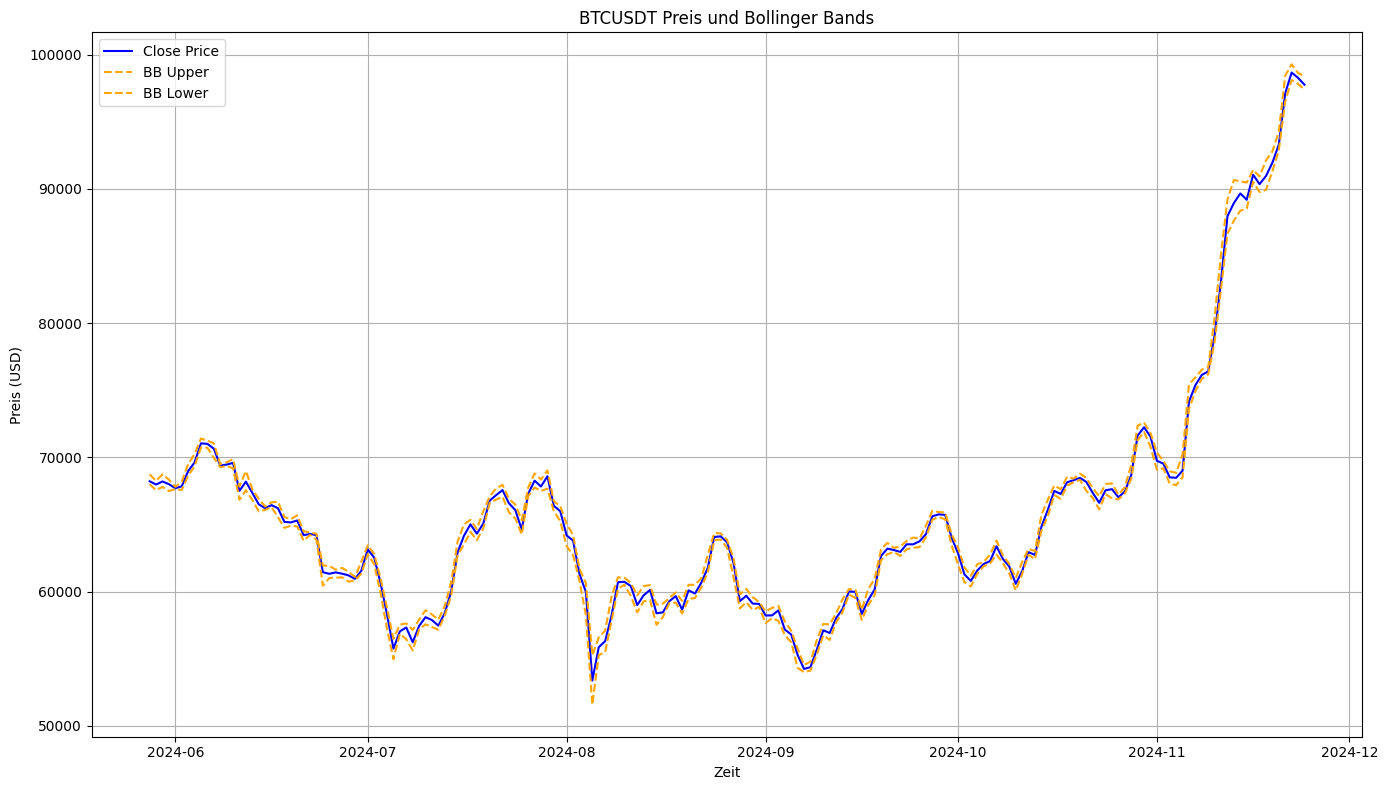

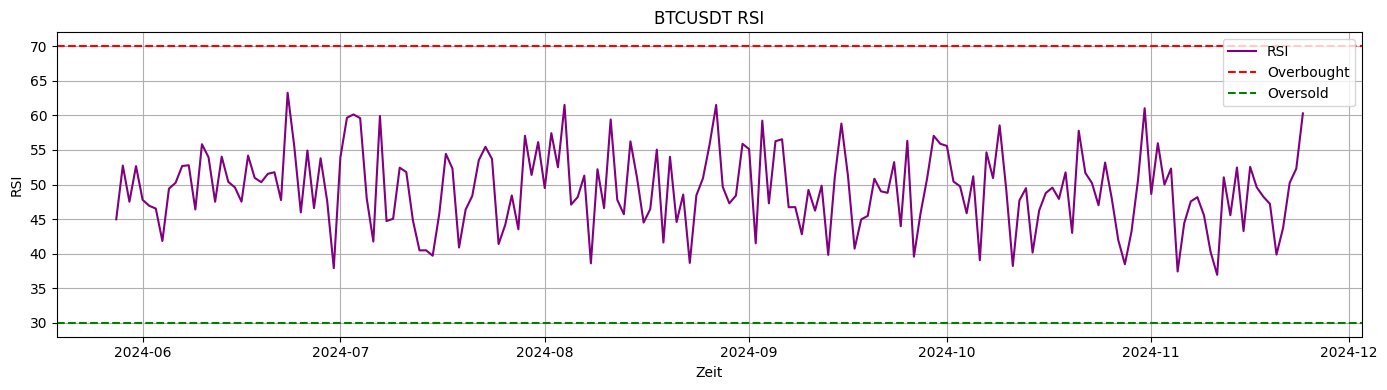

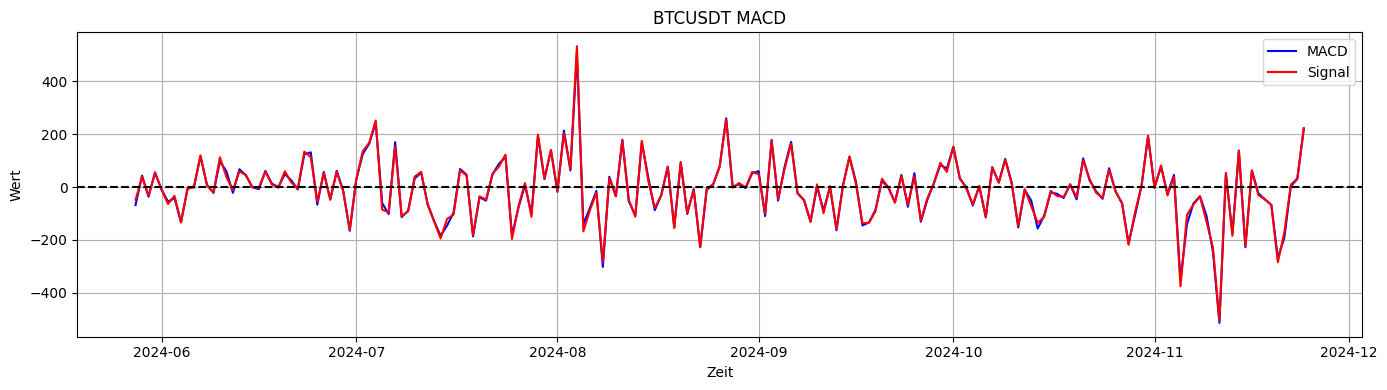

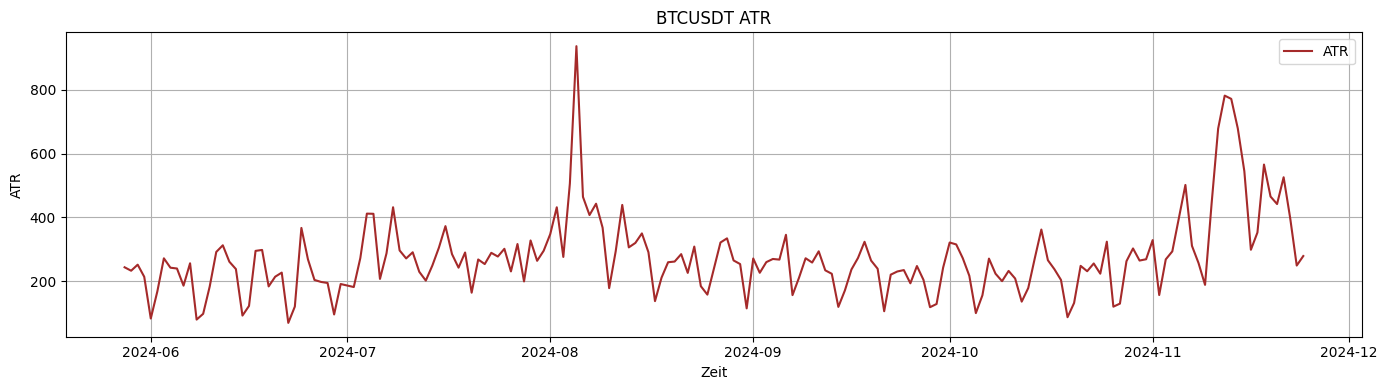

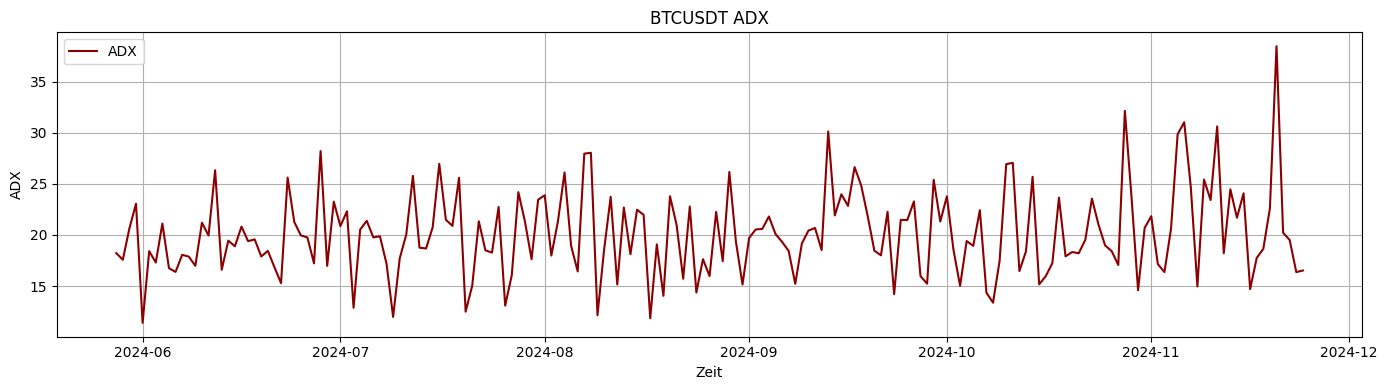

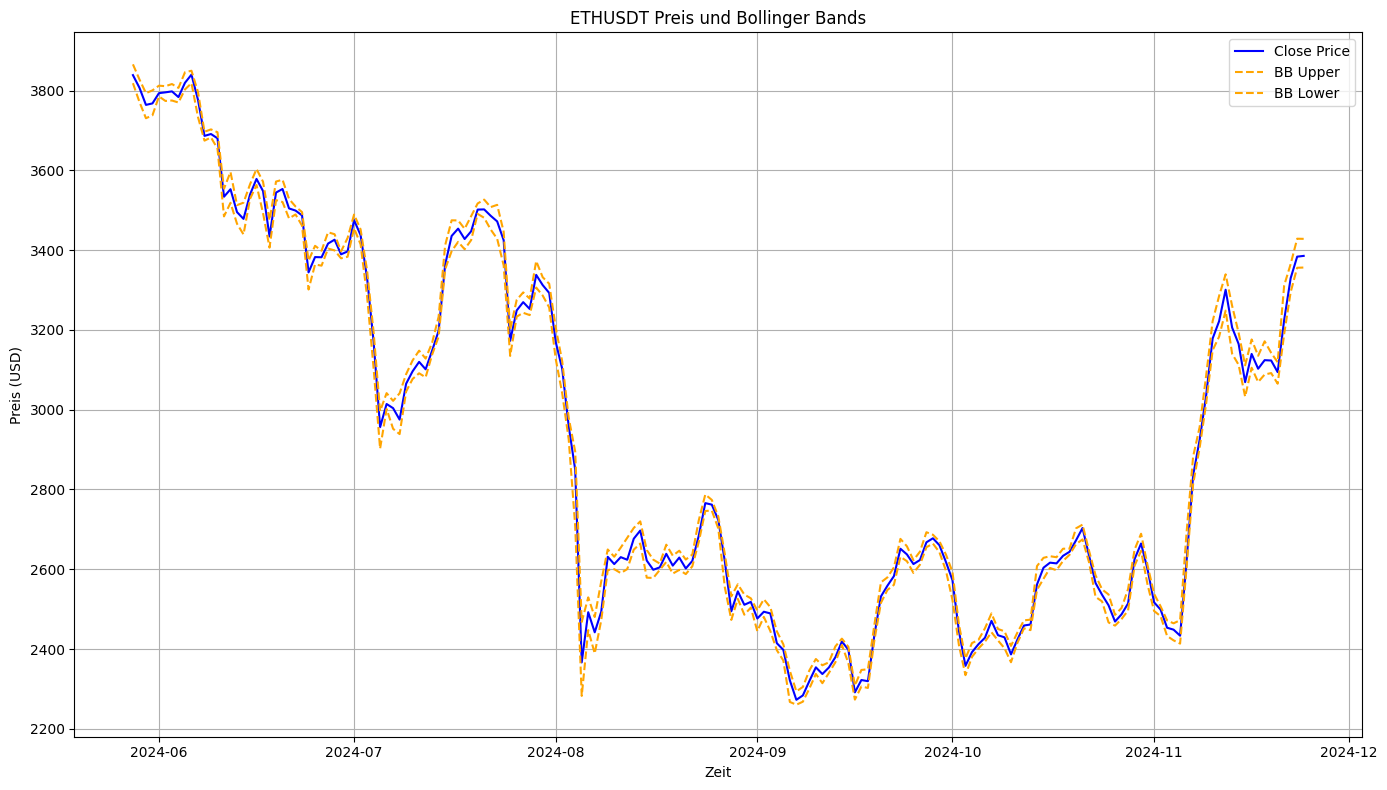

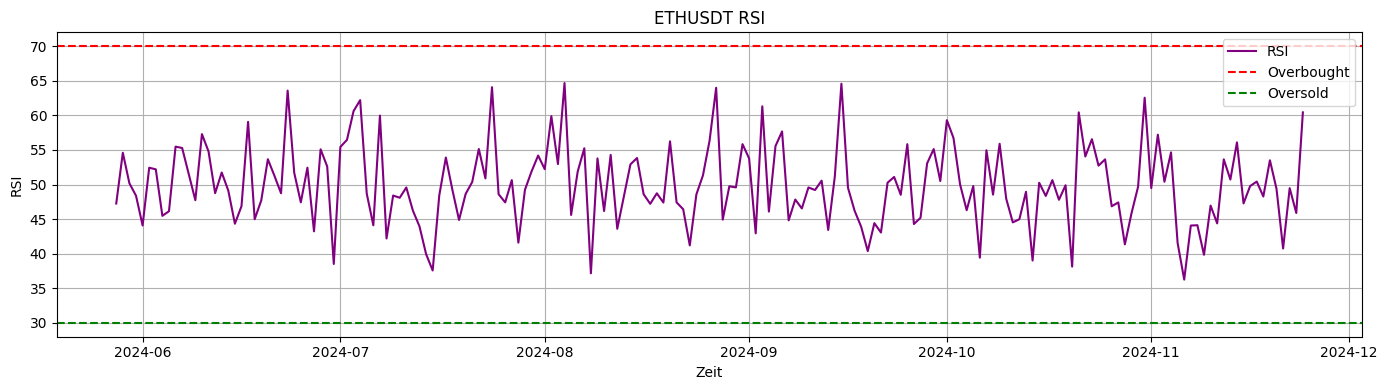

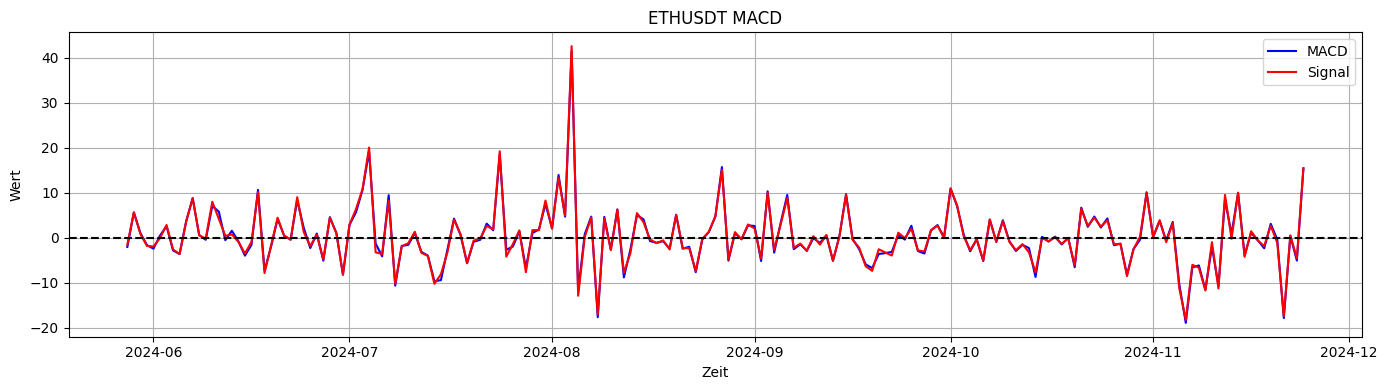

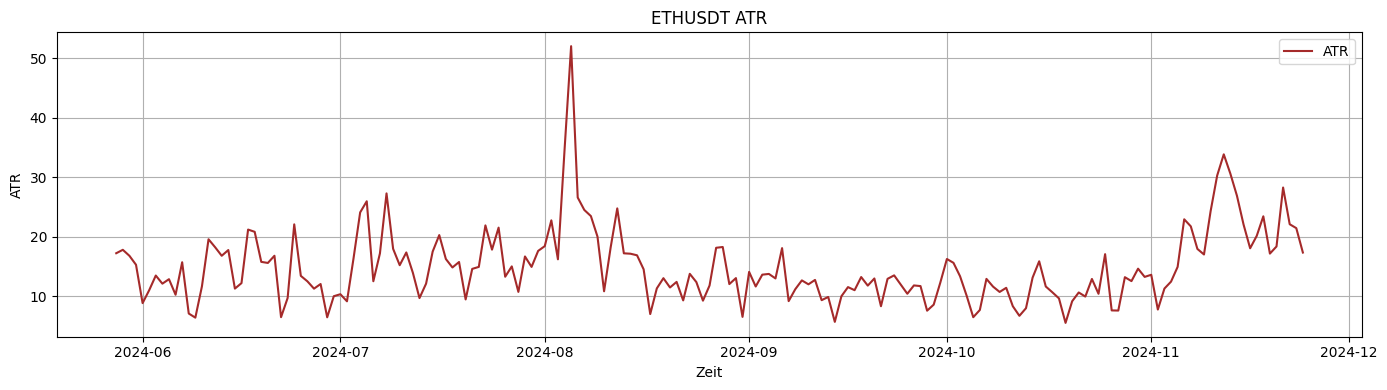

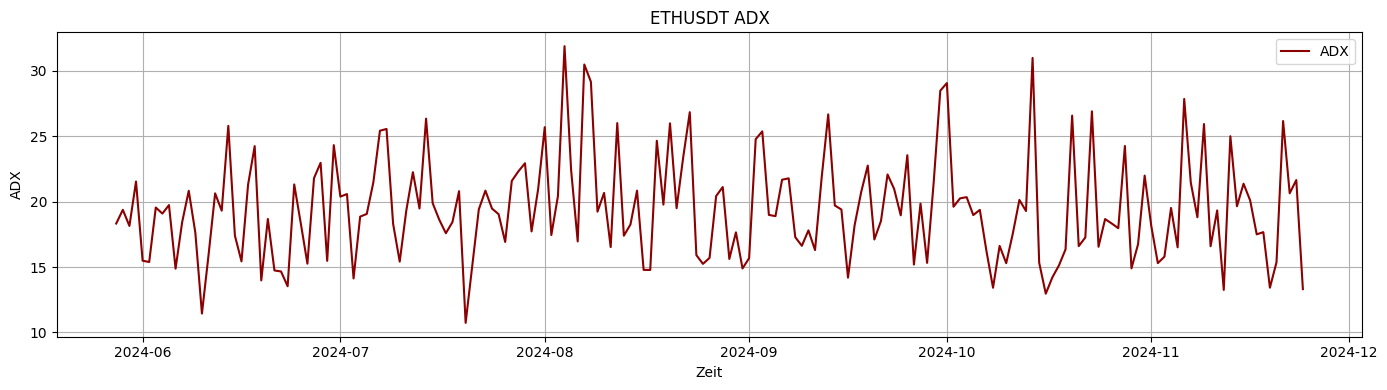

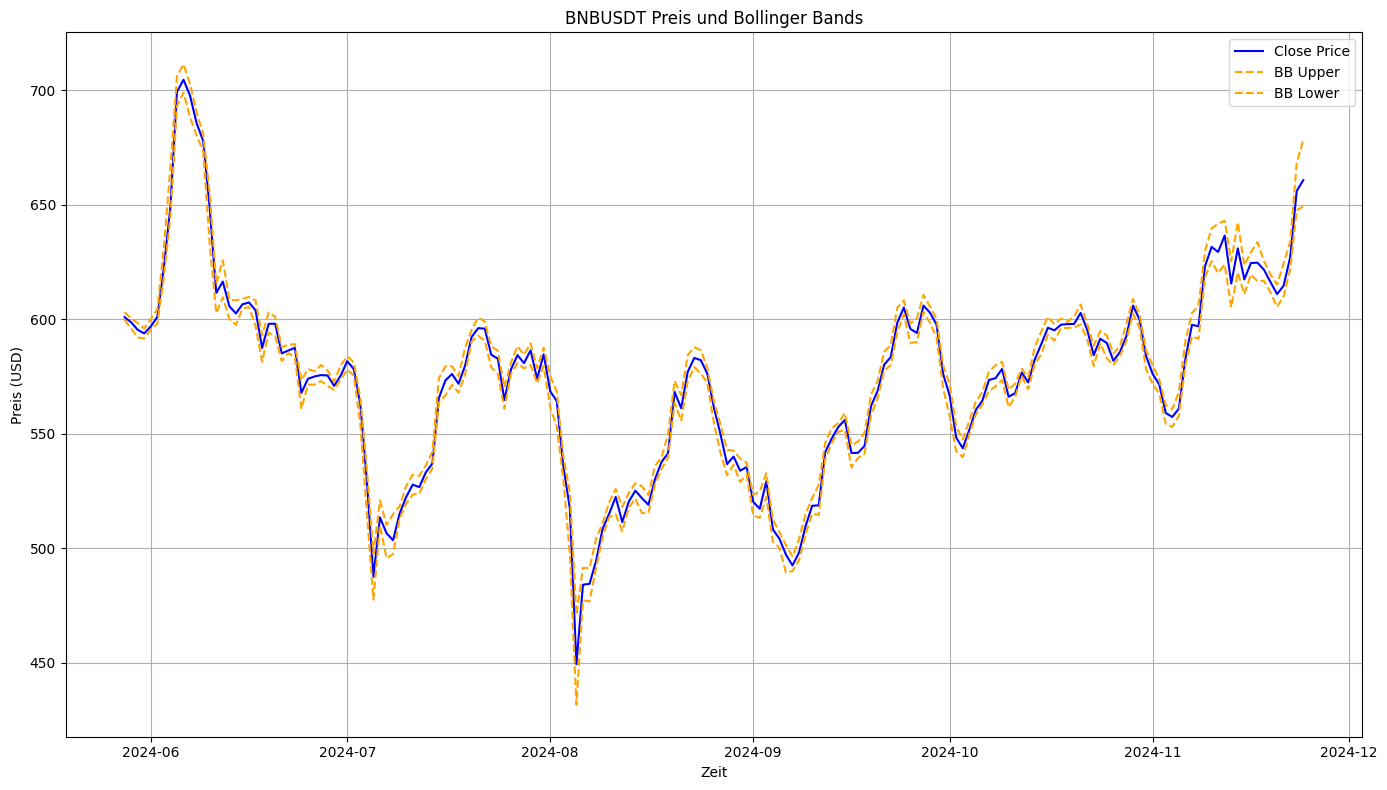

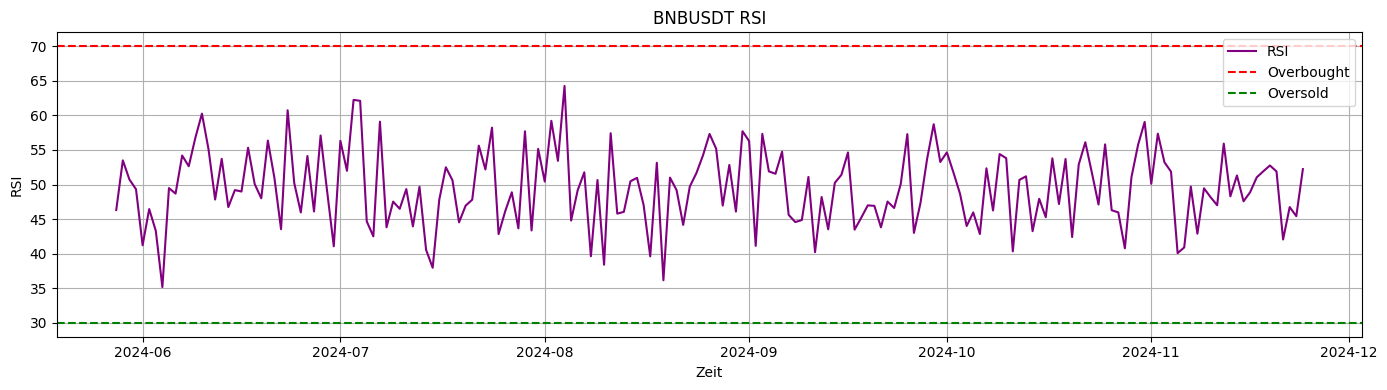

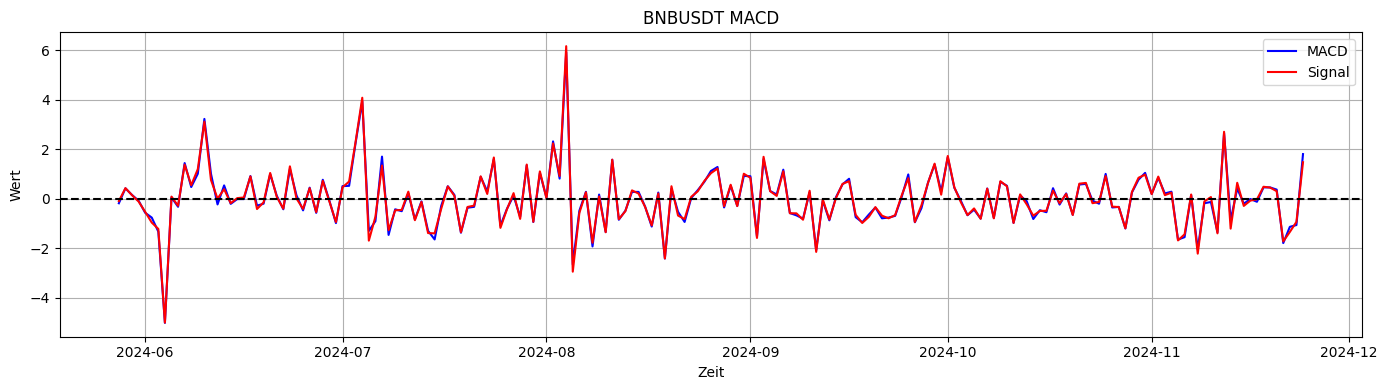

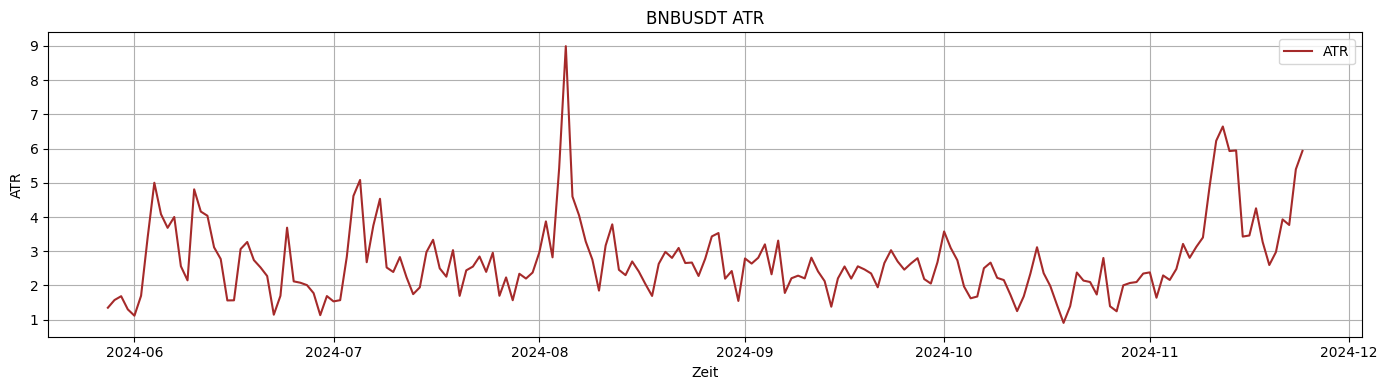

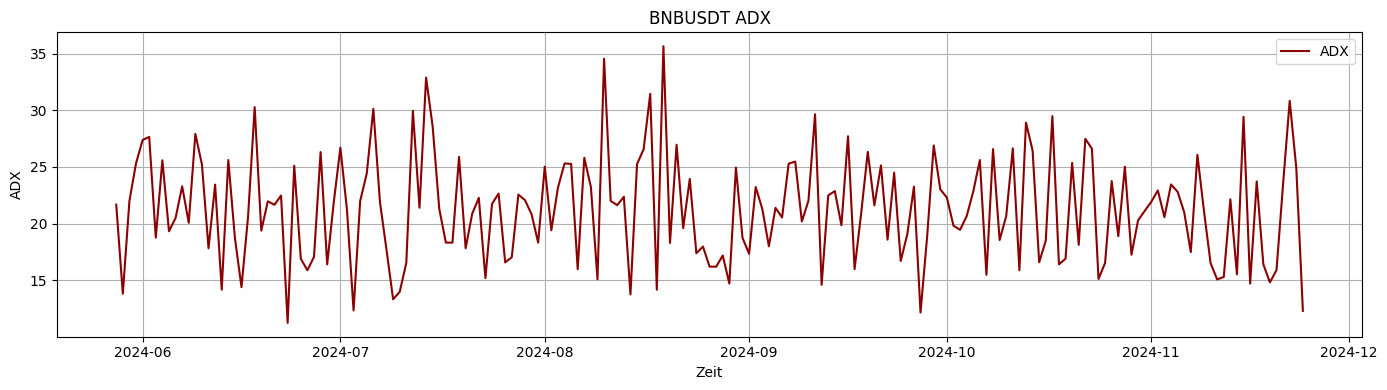

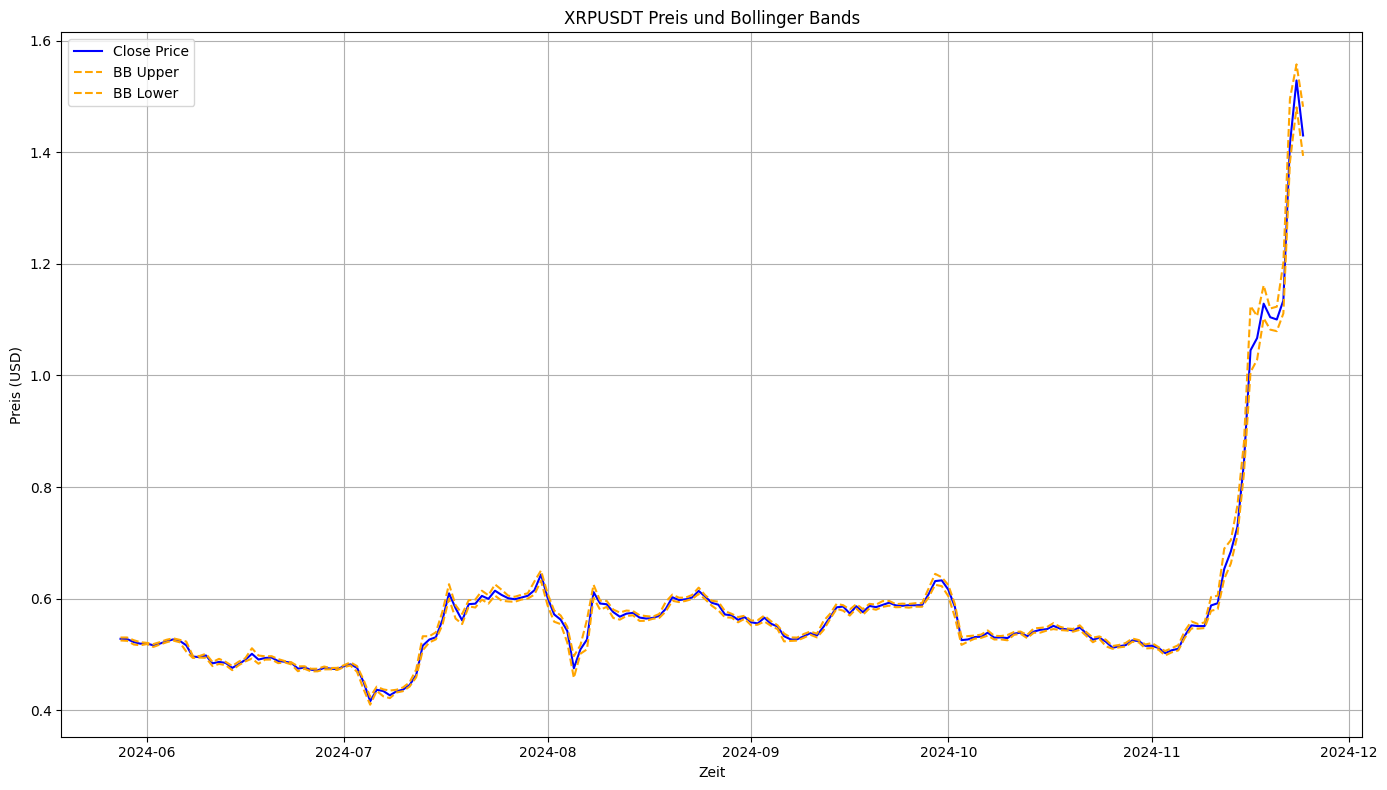

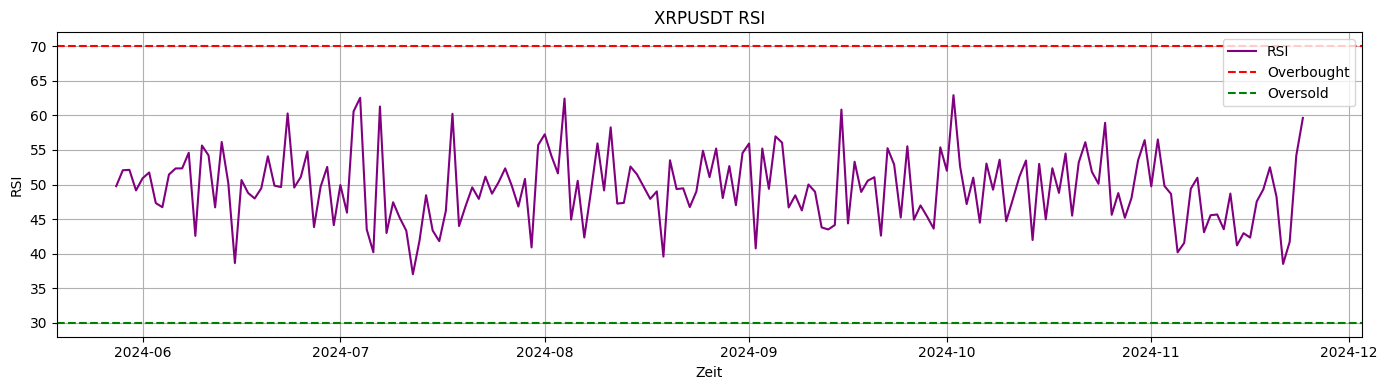

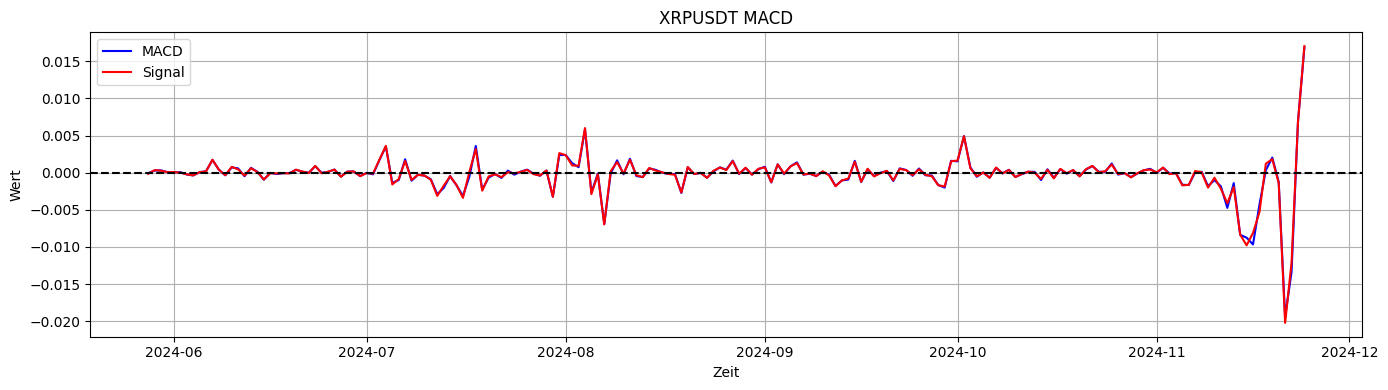

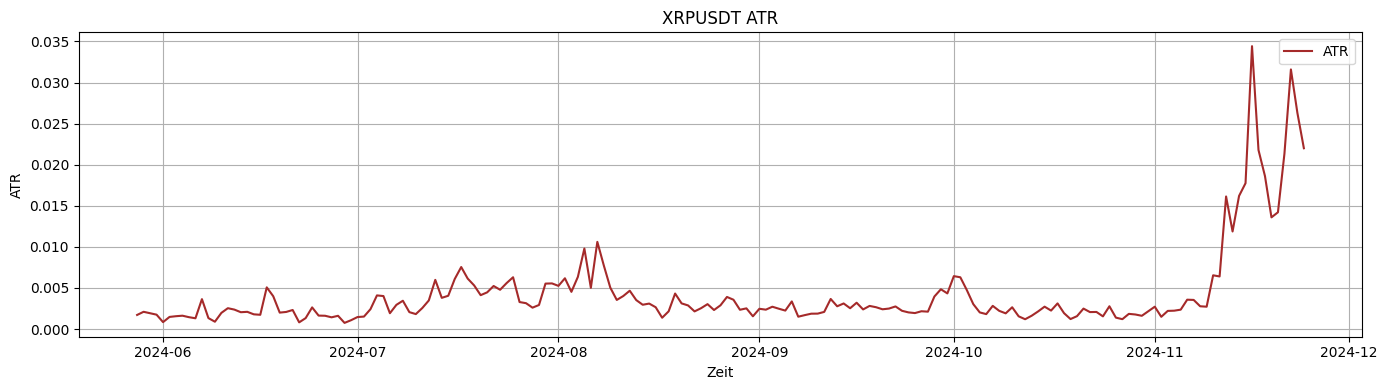

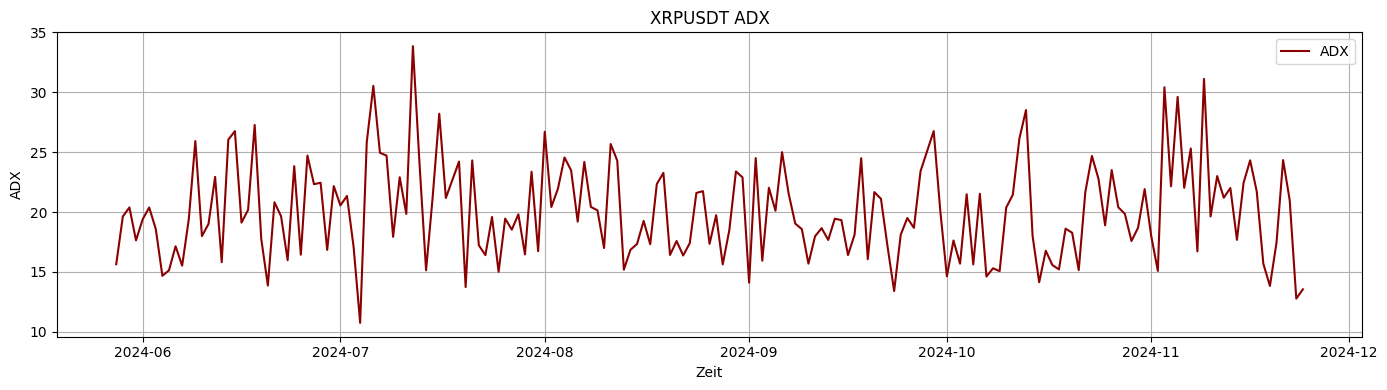

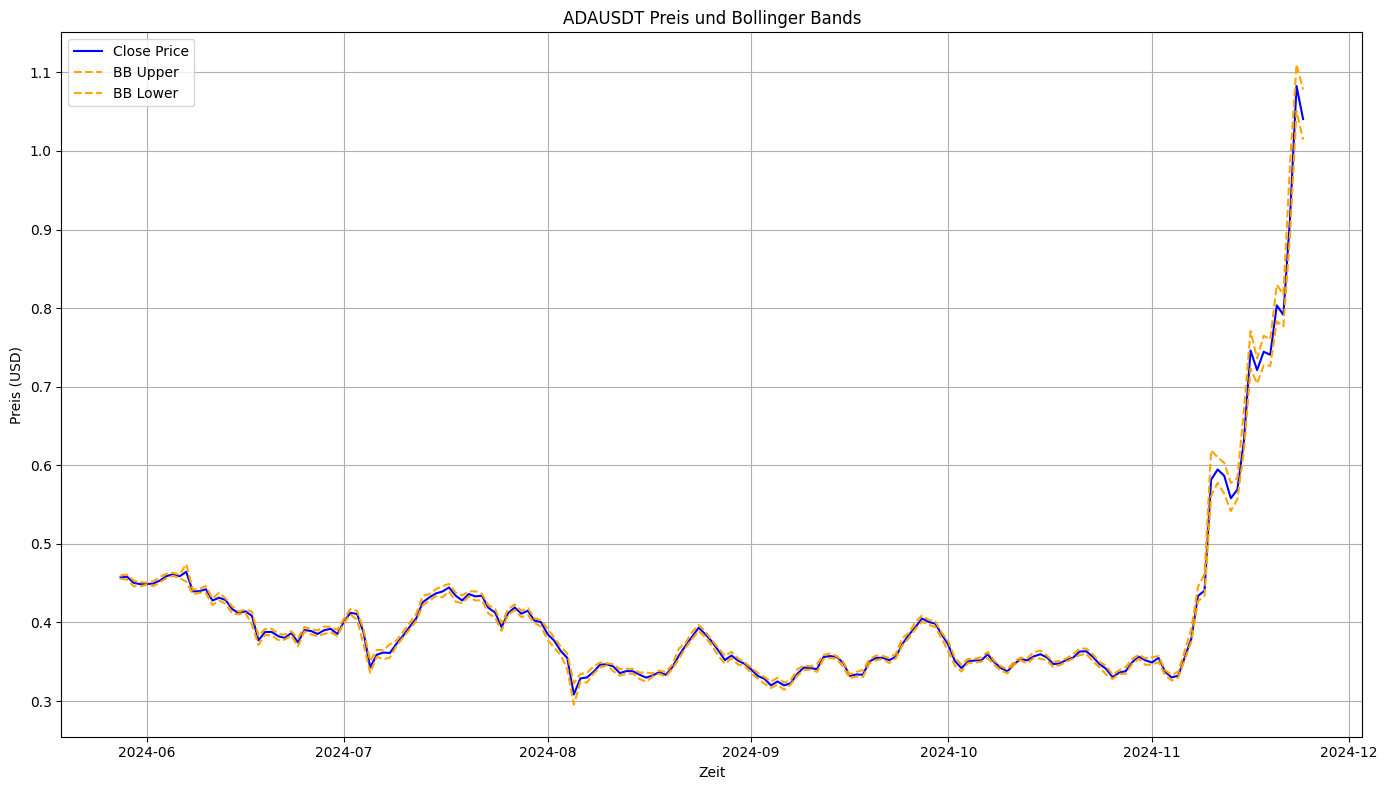

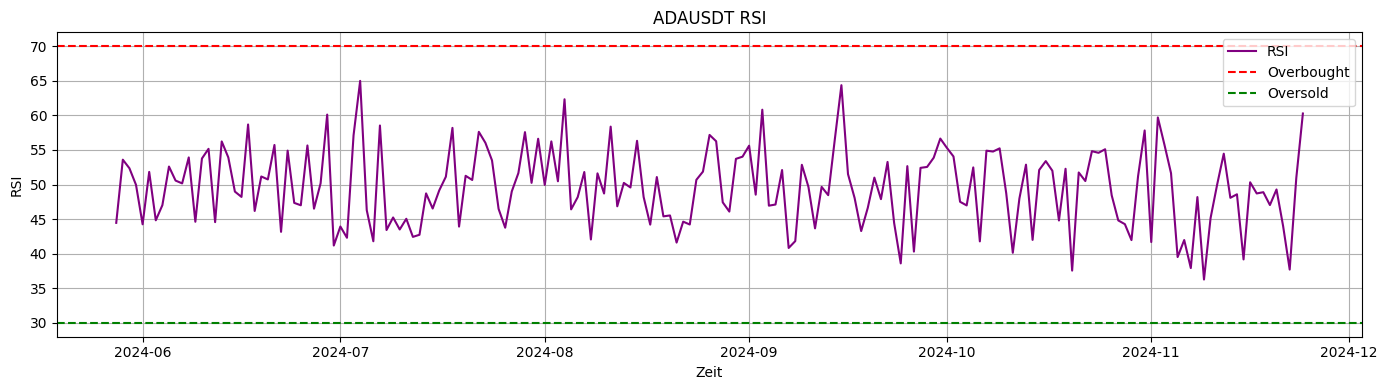

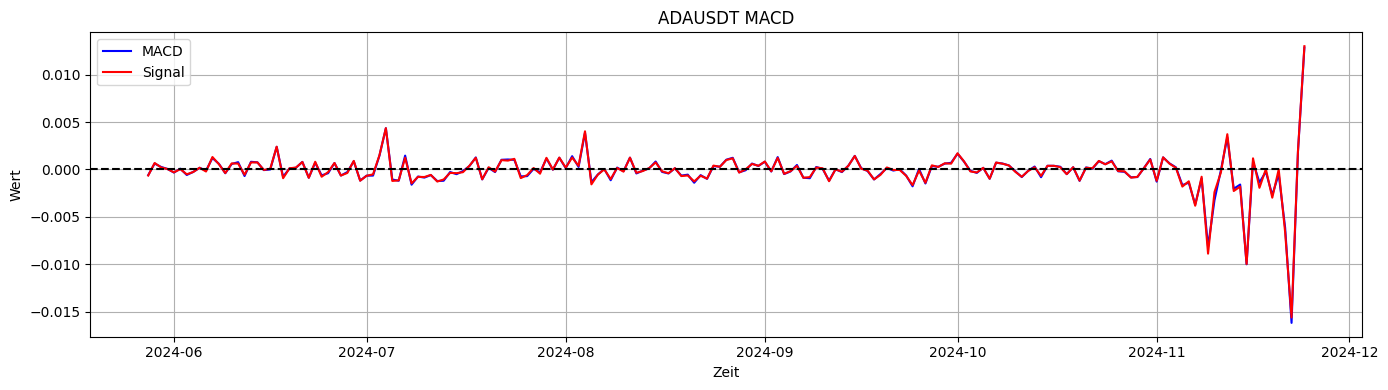

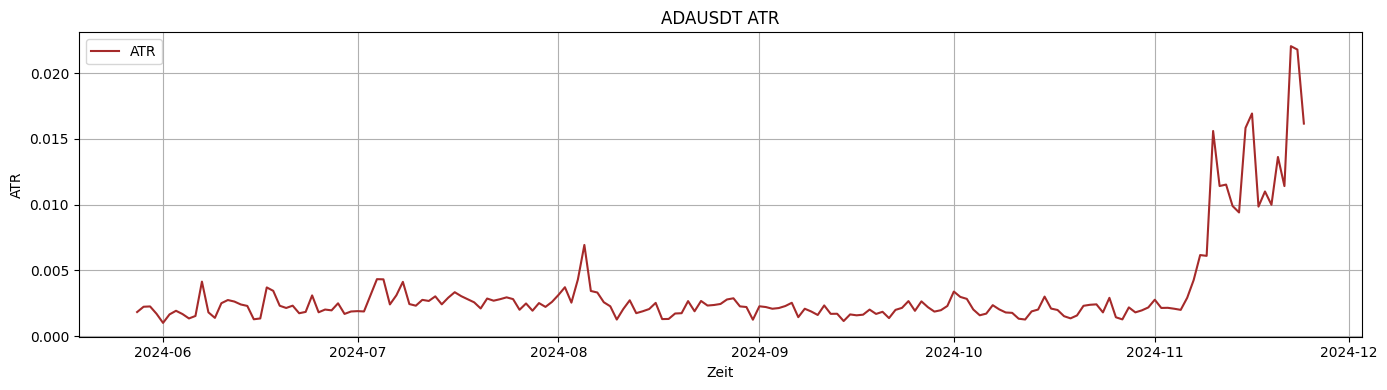

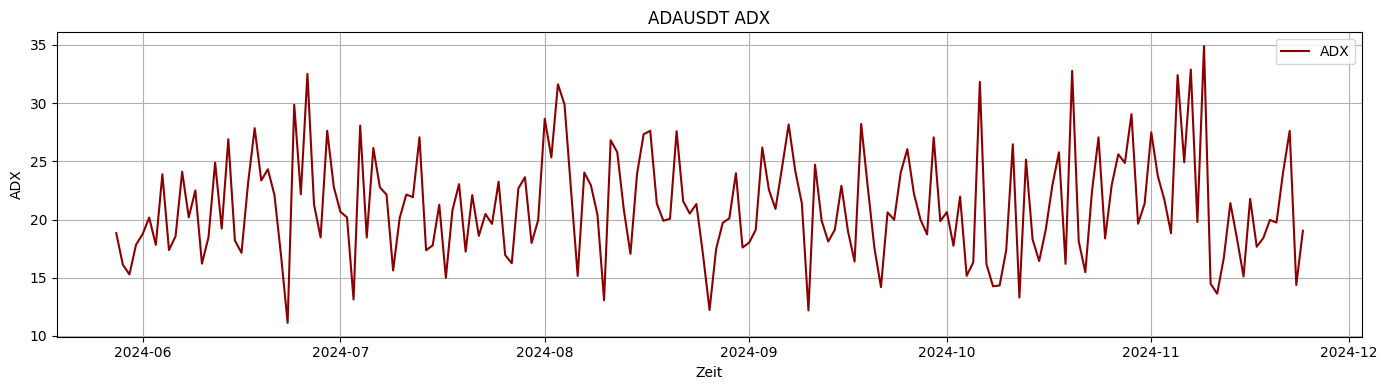

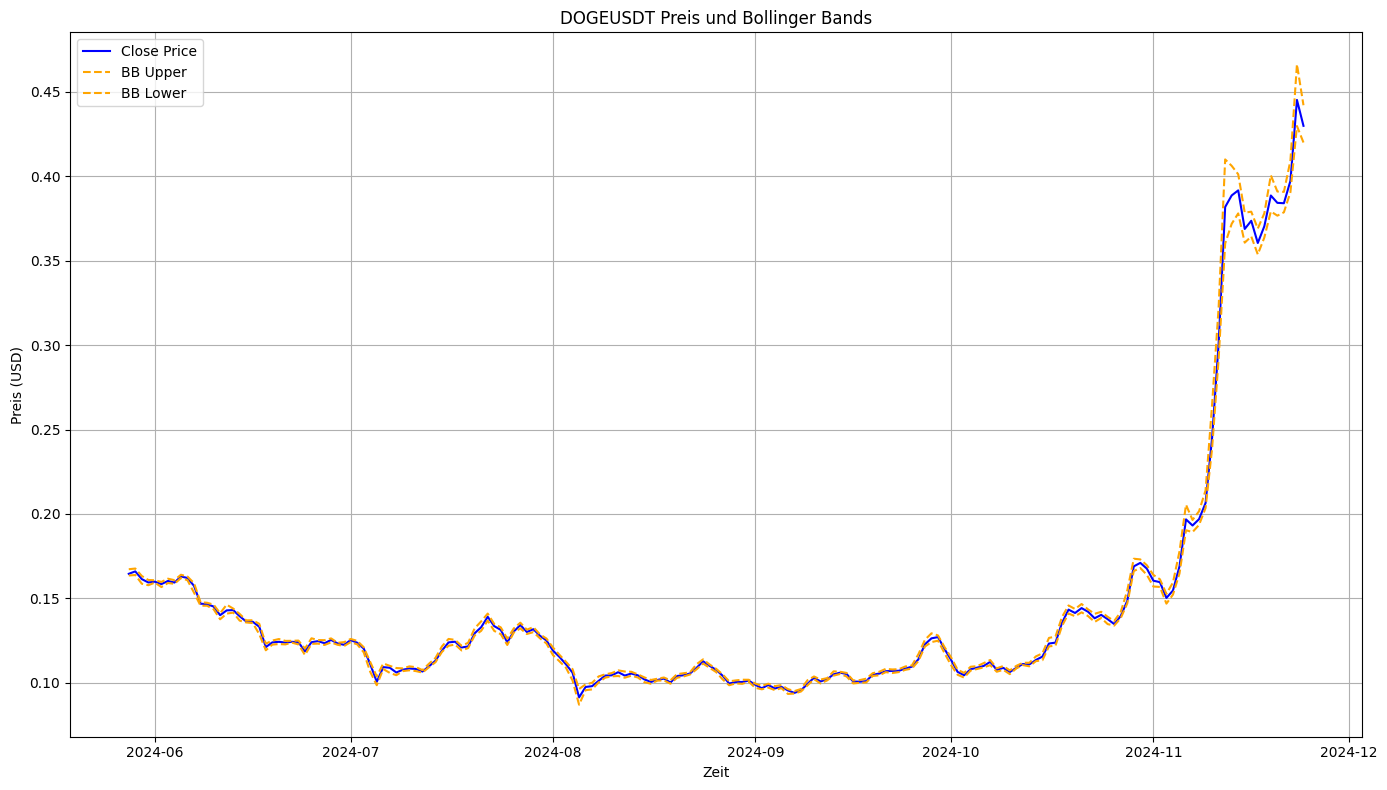

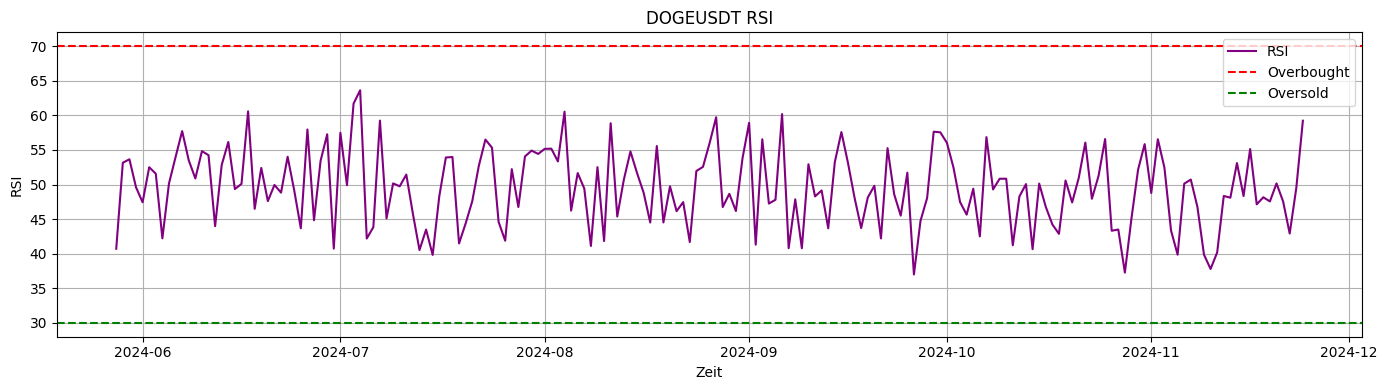

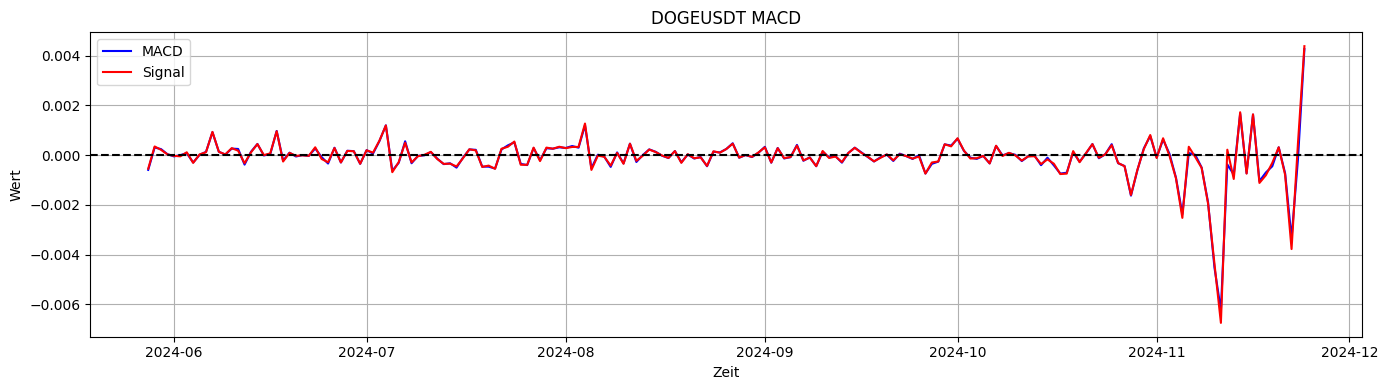

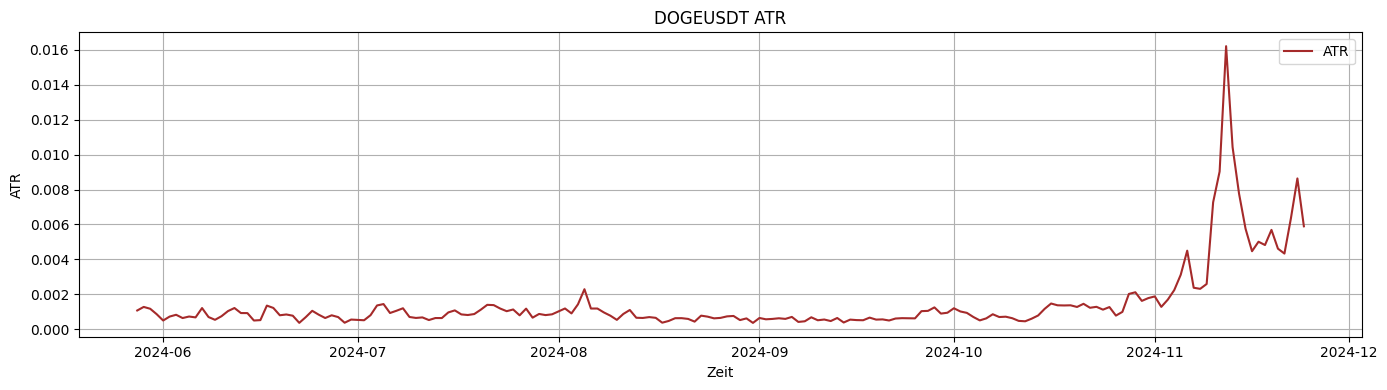

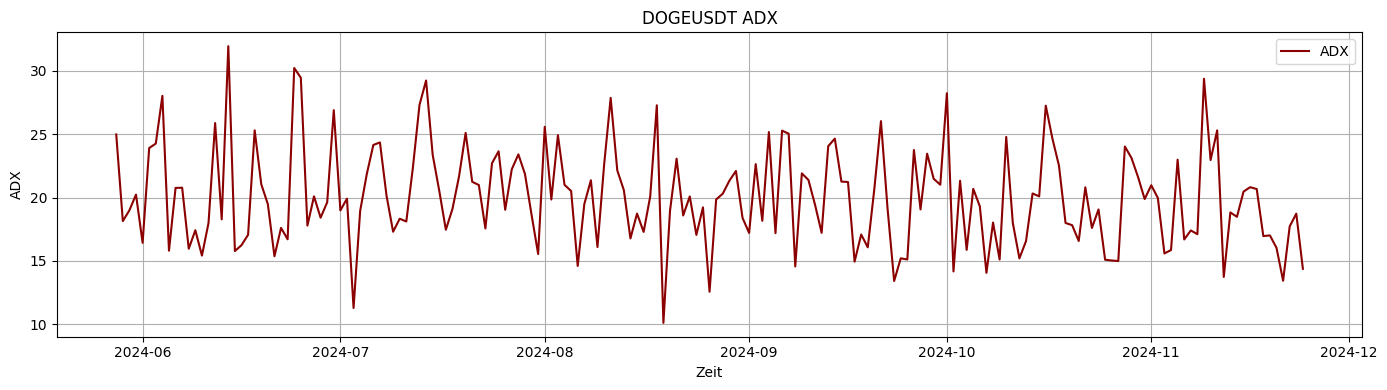

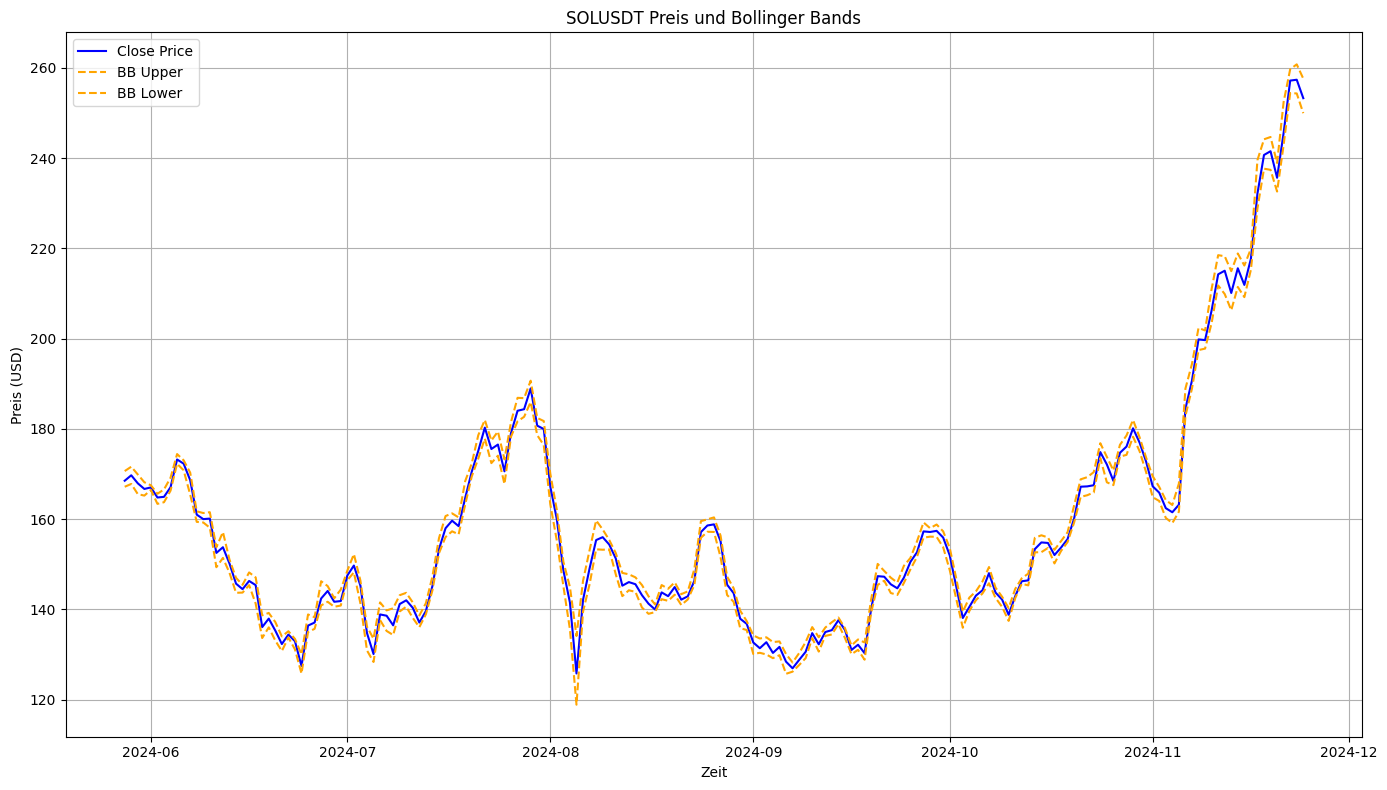

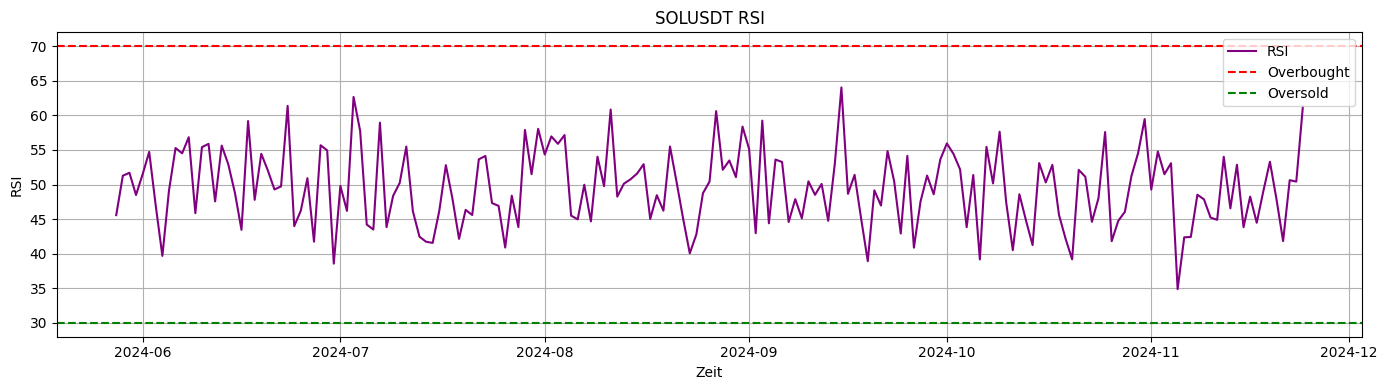

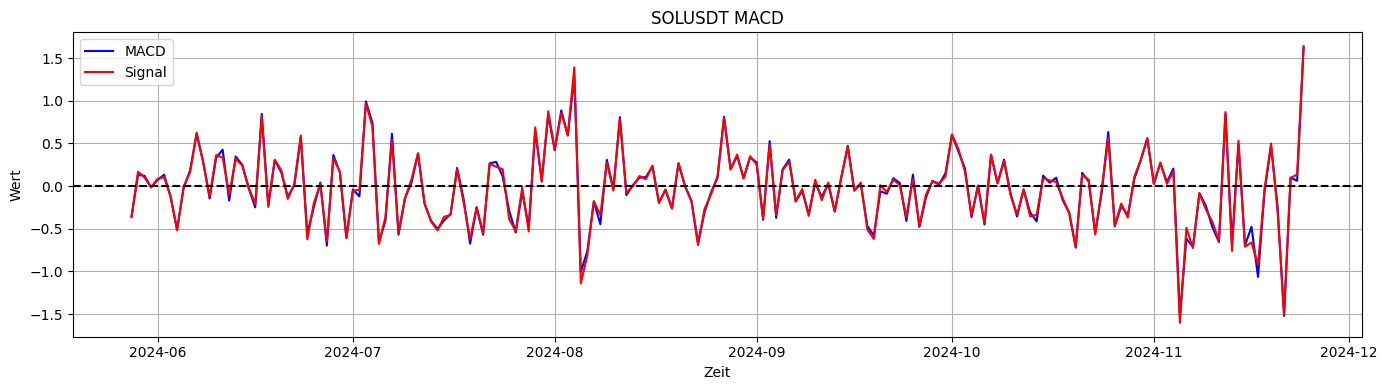

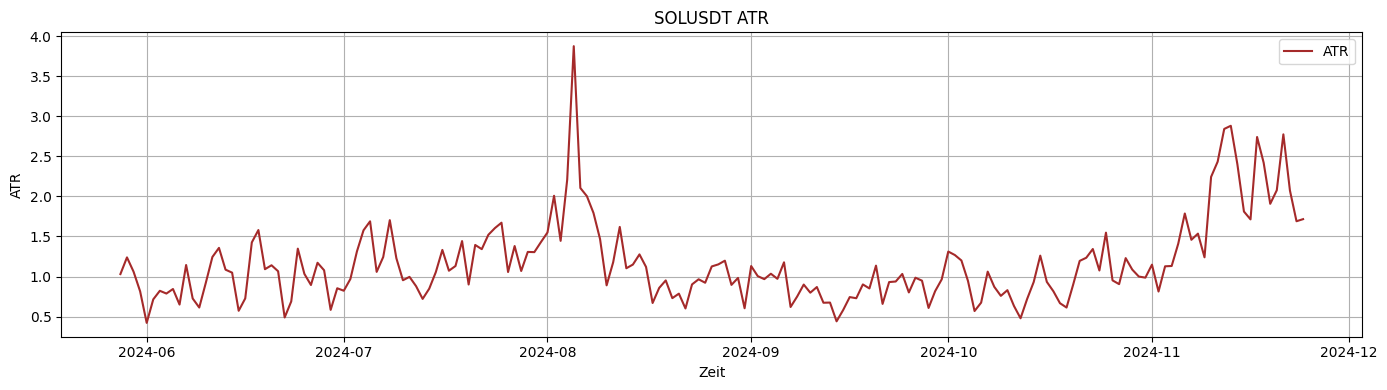

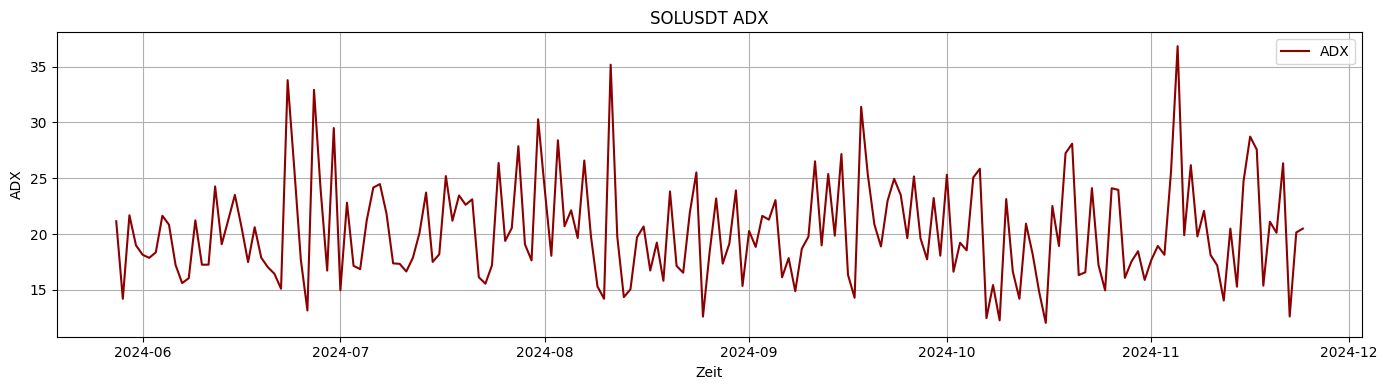

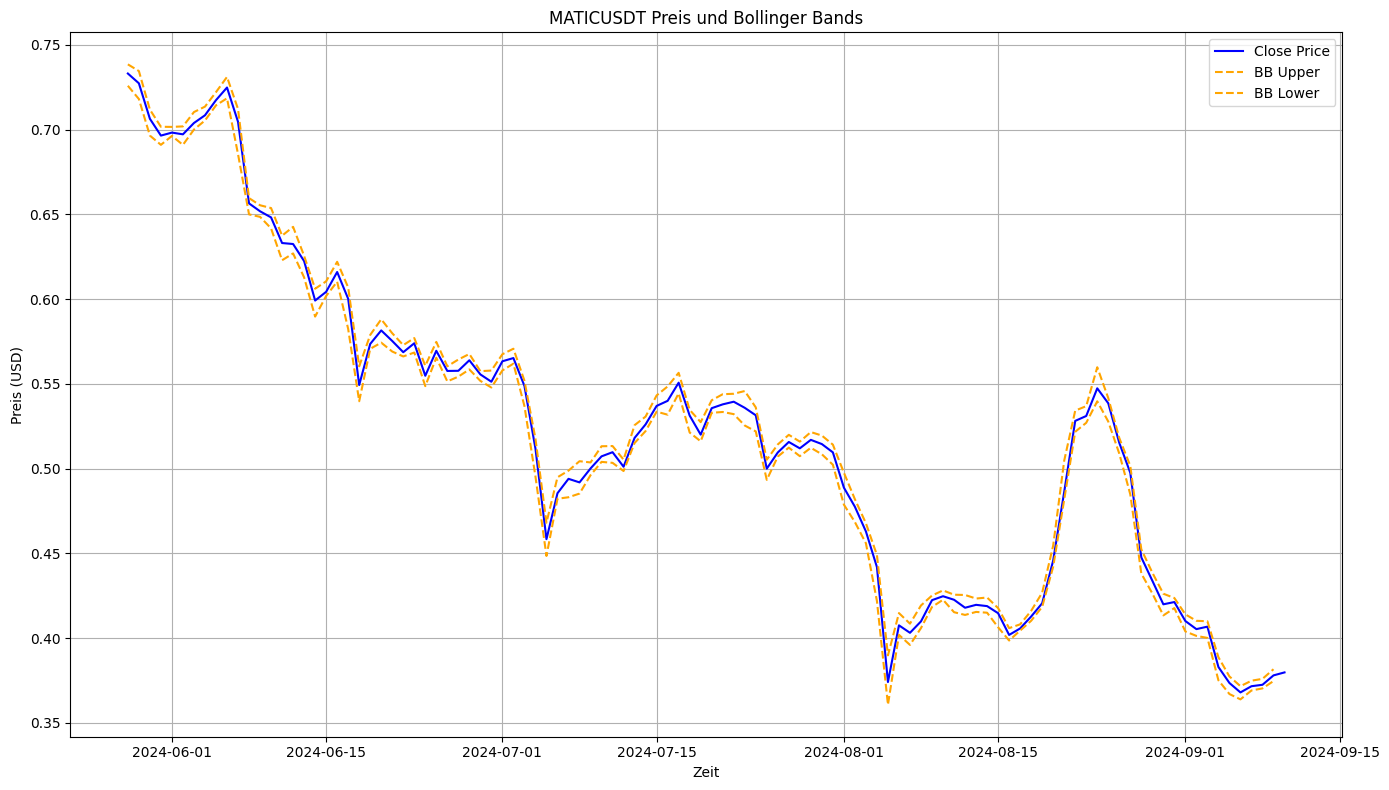

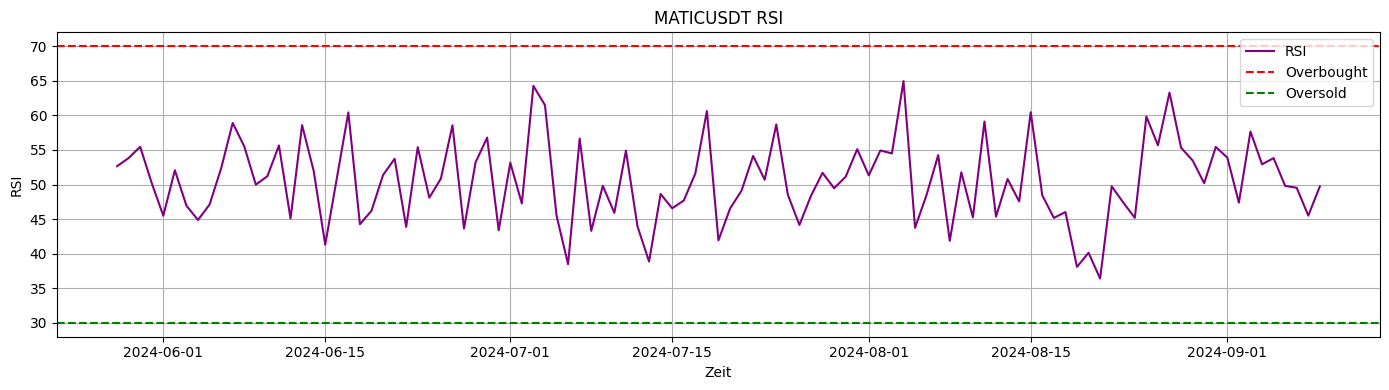

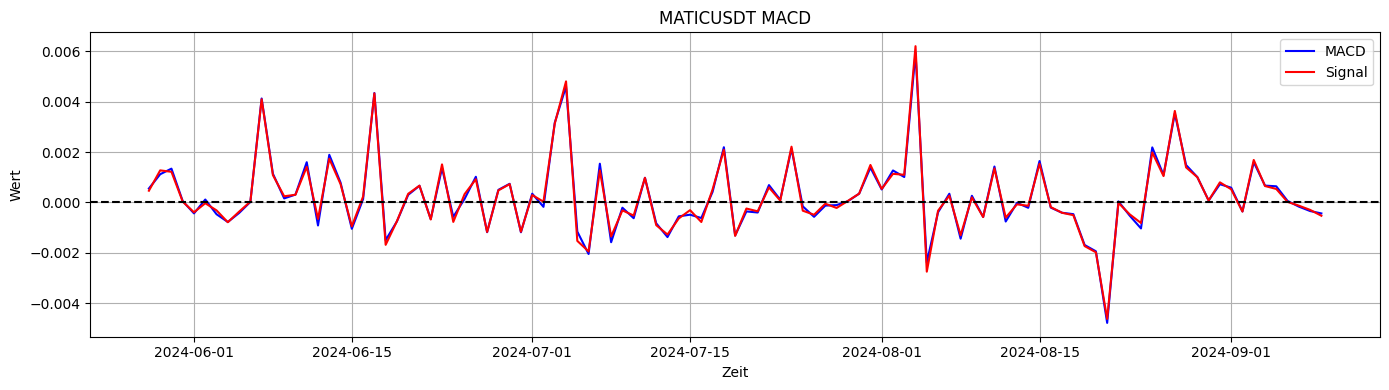

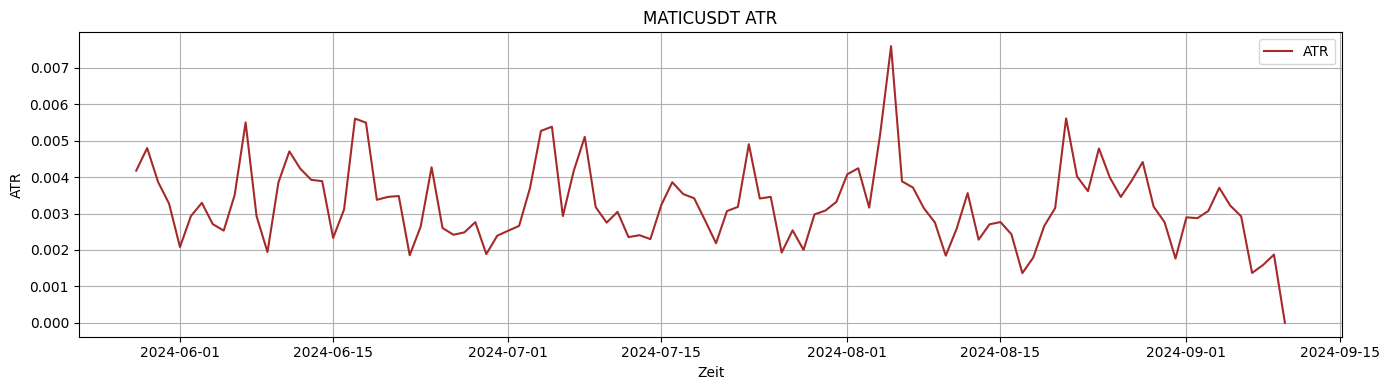

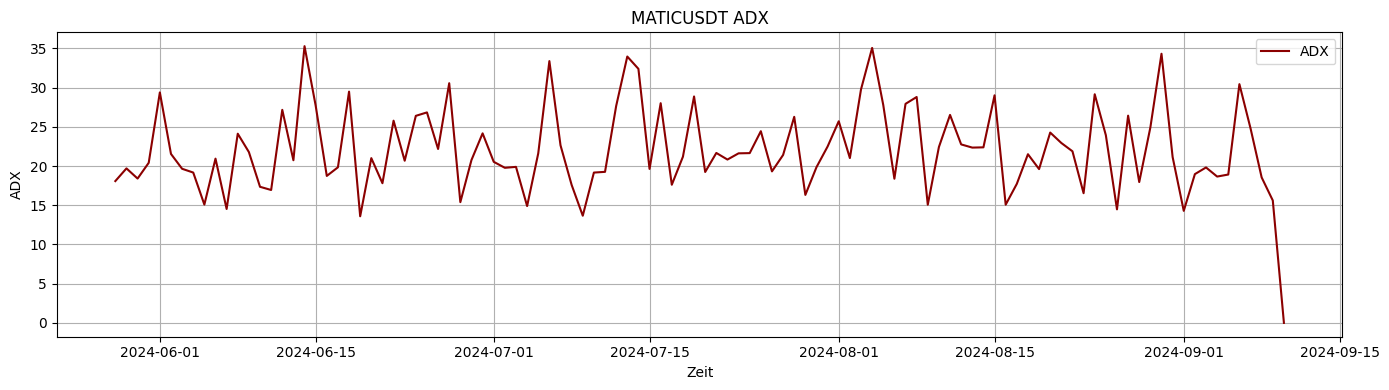

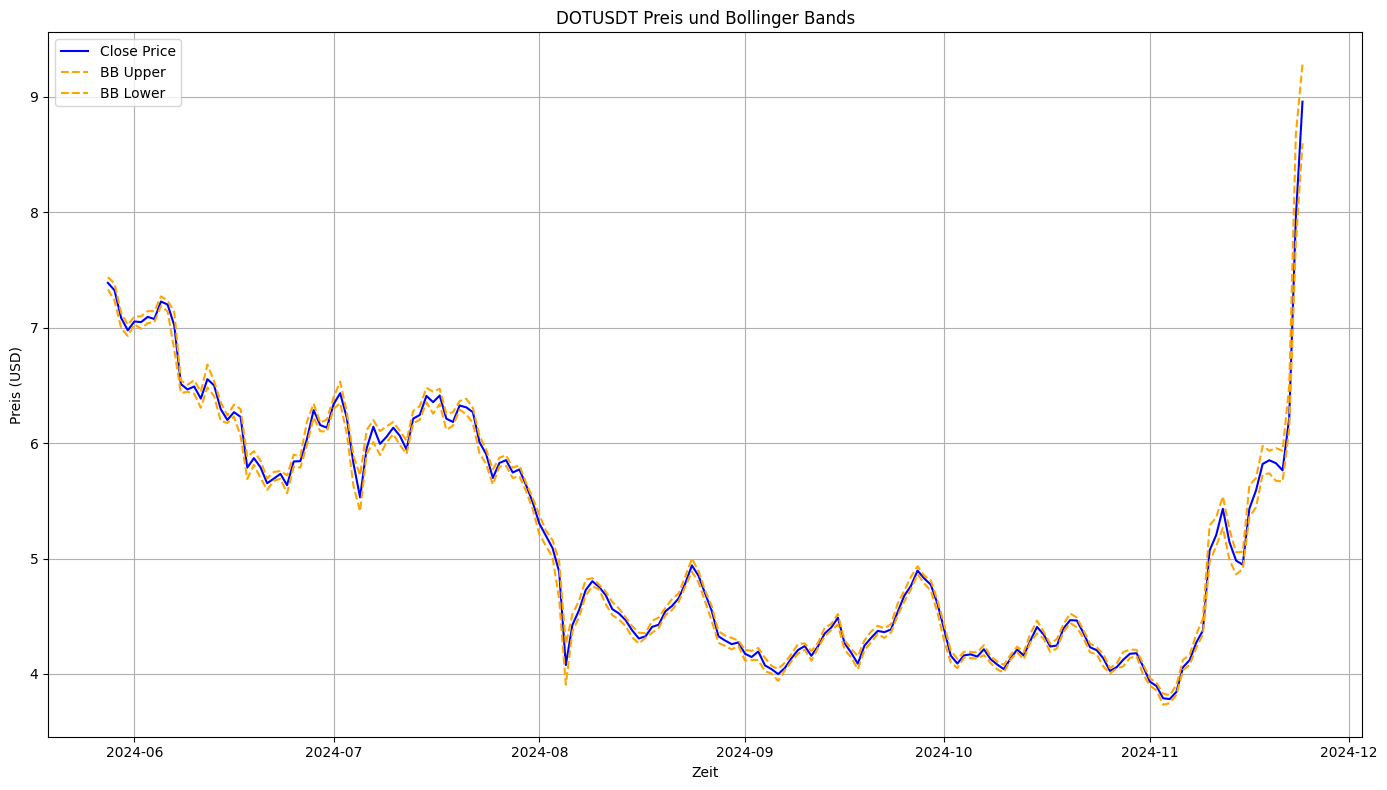

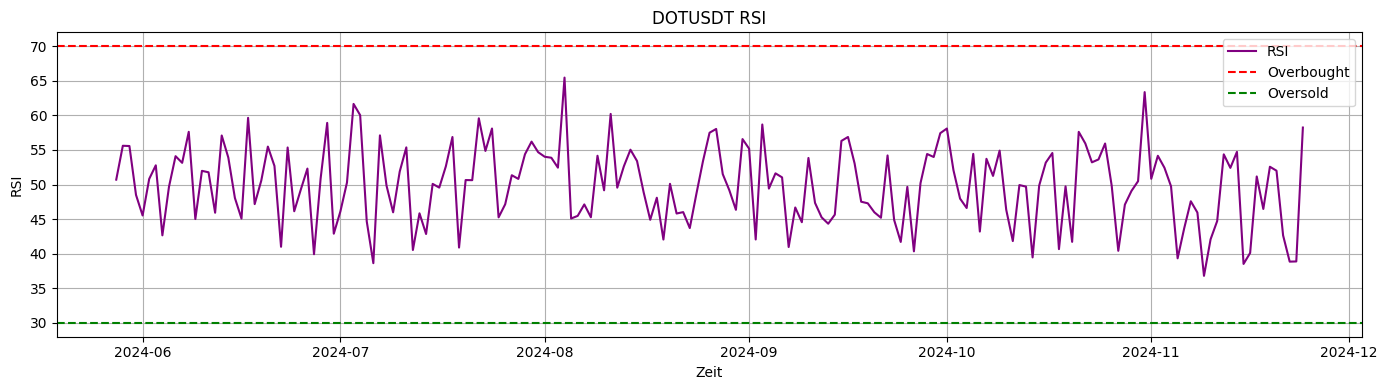

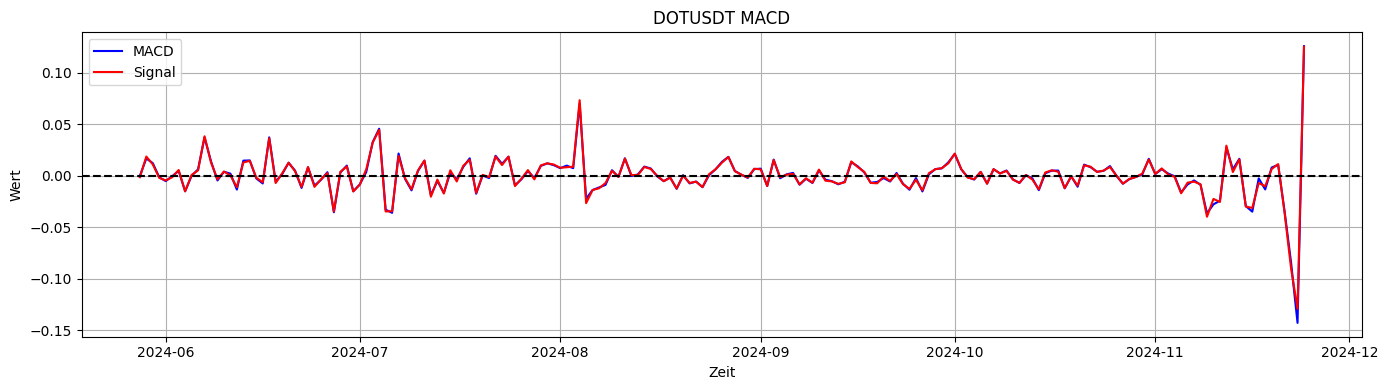

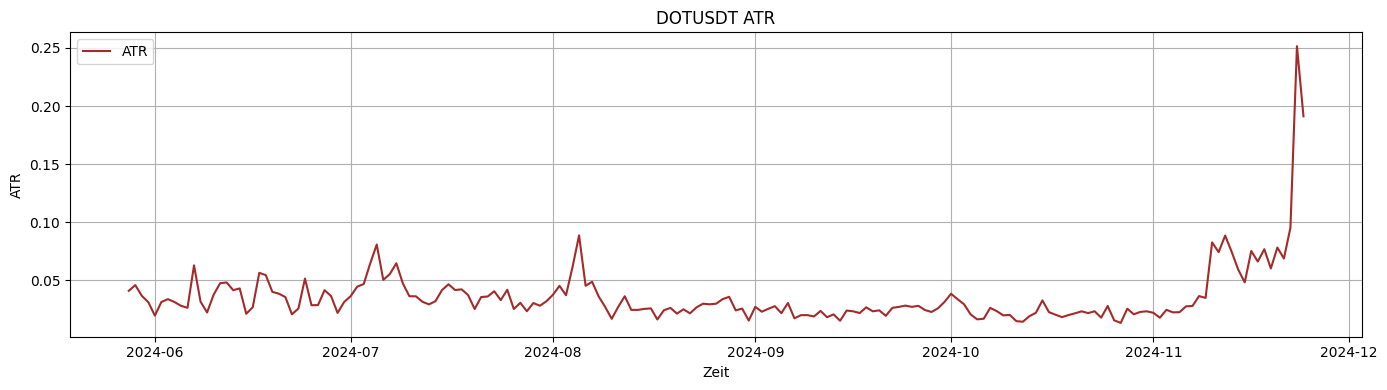

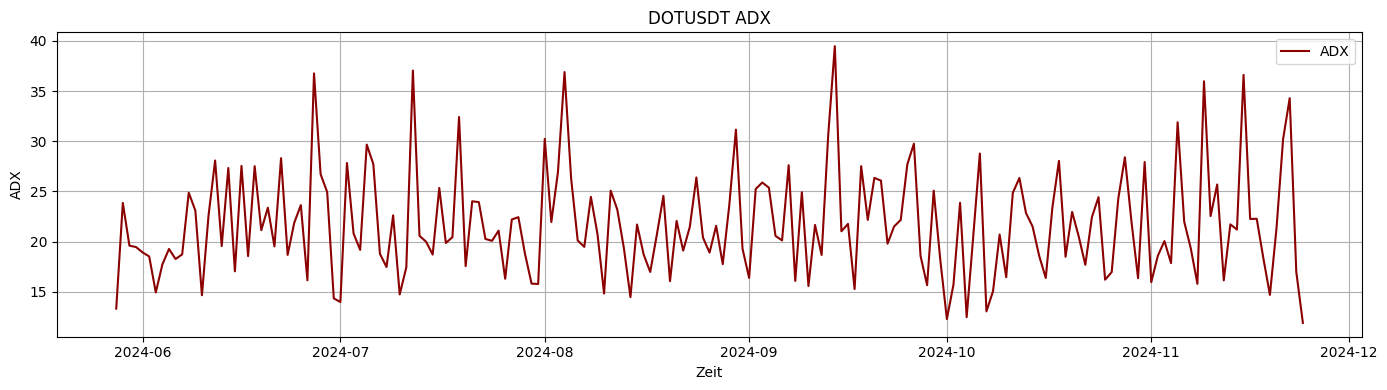

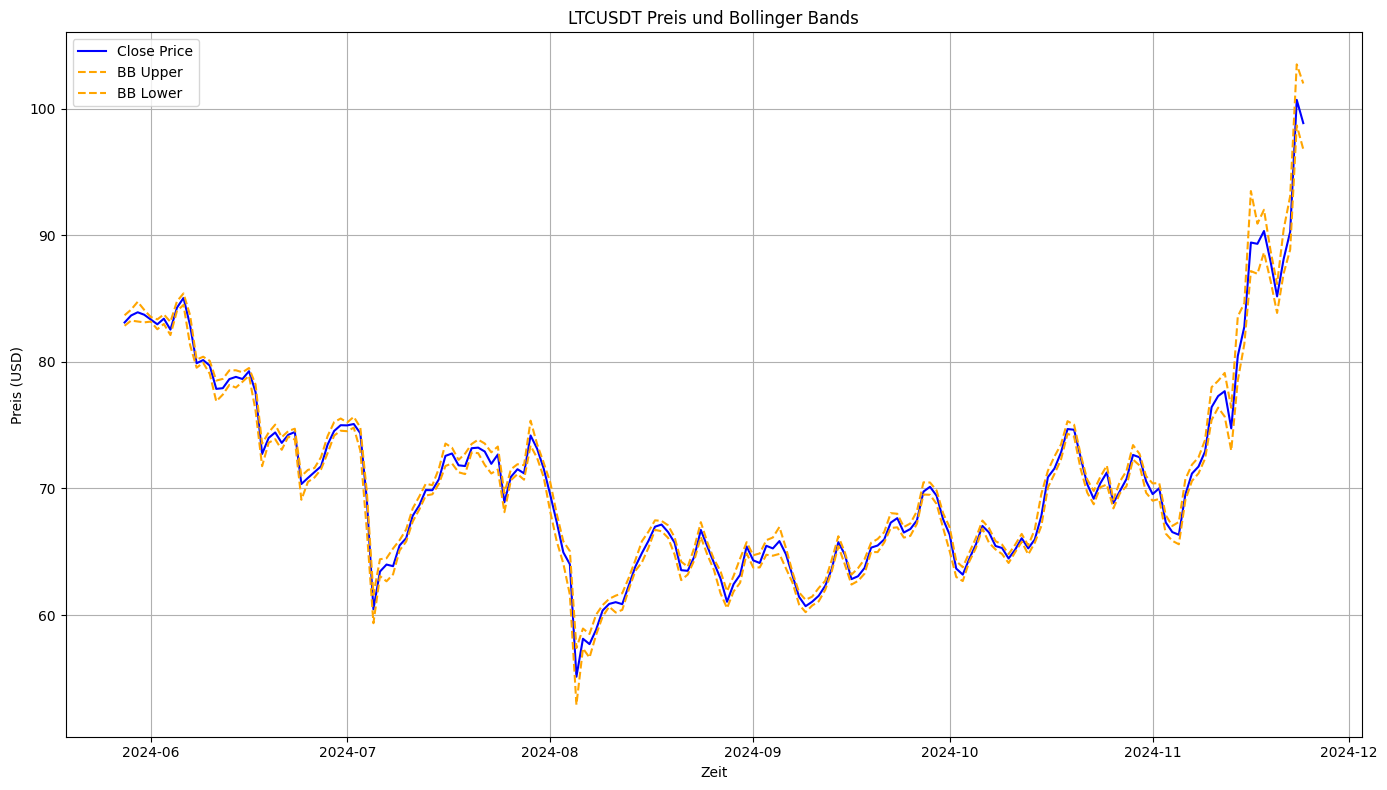

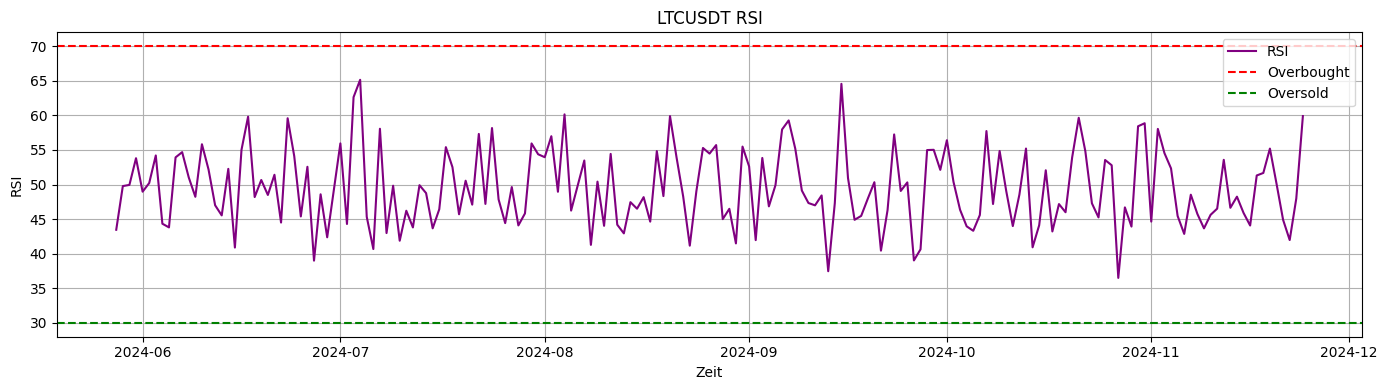

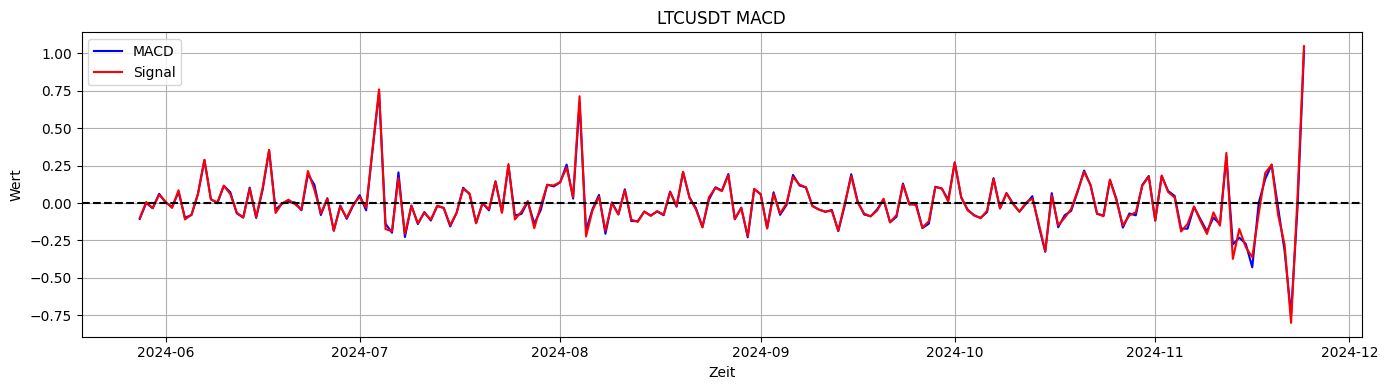

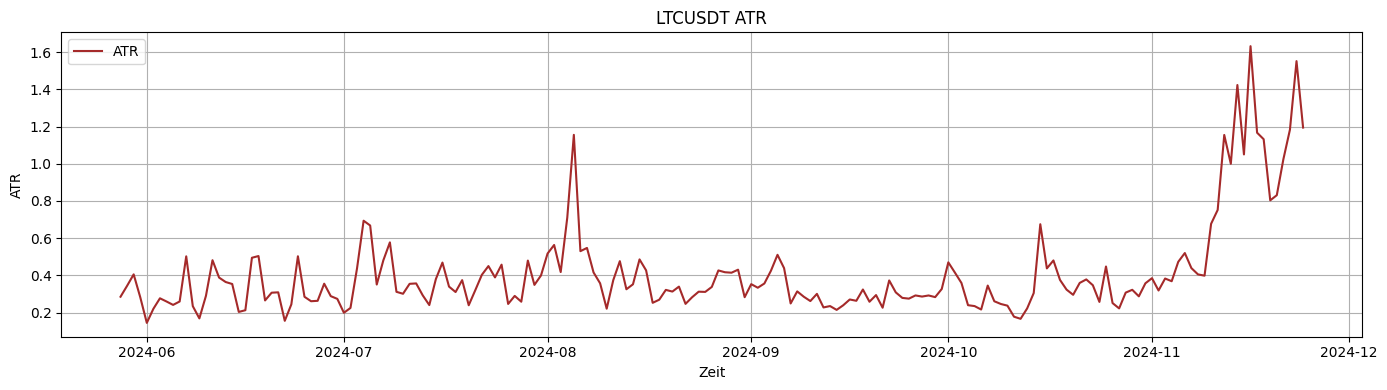

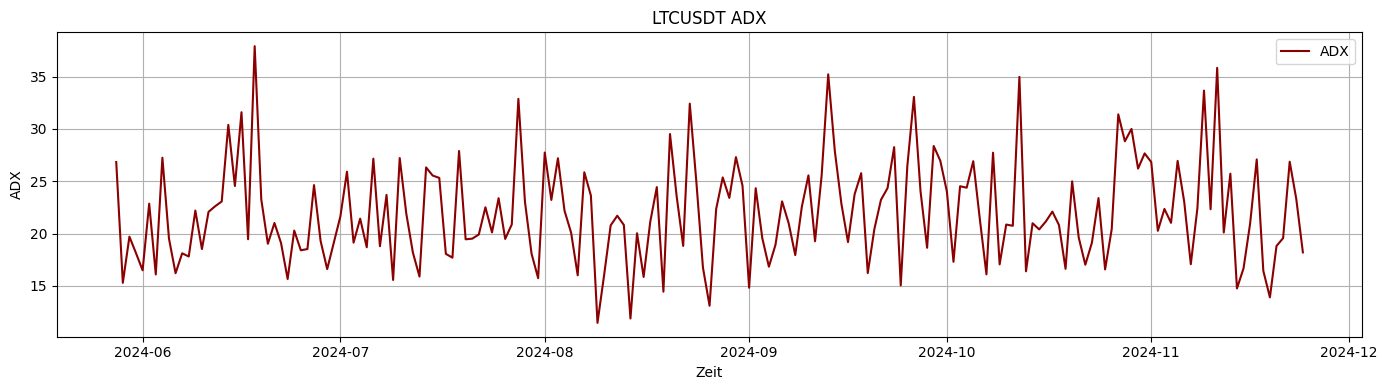

In [28]:
import matplotlib.pyplot as plt
import pandas as pd
from ta.momentum import RSIIndicator, StochasticOscillator
from ta.trend import MACD, ADXIndicator
from ta.volatility import BollingerBands, AverageTrueRange

def calculate_indicators(coin_data):
    # Sicherstellen, dass numerische Spalten korrekt konvertiert sind
    for column in ["Open", "Close", "High", "Low"]:
        coin_data[column] = pd.to_numeric(coin_data[column], errors="coerce")
    
    # RSI (Relative Strength Index)
    coin_data["RSI"] = RSIIndicator(close=coin_data["Close"], window=14).rsi()

    # MACD (Moving Average Convergence Divergence)
    macd = MACD(close=coin_data["Close"])
    coin_data["MACD"] = macd.macd()
    coin_data["Signal"] = macd.macd_signal()

    # Stochastic Oscillator
    stoch = StochasticOscillator(high=coin_data["High"], low=coin_data["Low"], close=coin_data["Close"])
    coin_data["Stoch %K"] = stoch.stoch()
    coin_data["Stoch %D"] = stoch.stoch_signal()

    # Bollinger Bands
    bb = BollingerBands(close=coin_data["Close"])
    coin_data["BB Upper"] = bb.bollinger_hband()
    coin_data["BB Lower"] = bb.bollinger_lband()

    # ATR (Average True Range)
    coin_data["ATR"] = AverageTrueRange(high=coin_data["High"], low=coin_data["Low"], close=coin_data["Close"]).average_true_range()

    # ADX (Average Directional Index)
    coin_data["ADX"] = ADXIndicator(high=coin_data["High"], low=coin_data["Low"], close=coin_data["Close"]).adx()

    return coin_data

def plot_with_indicators(coin_name, coin_data, resample_interval="1D"):
    # Resample-Daten auf Tagesbasis (falls erforderlich)
    coin_data["Open Time"] = pd.to_datetime(coin_data["Open Time"])
    coin_data = coin_data.resample(resample_interval, on="Open Time").mean()

    # Plot Preis und Bollinger Bands
    plt.figure(figsize=(14, 8))
    plt.plot(coin_data.index, coin_data["Close"], label="Close Price", color="blue", linewidth=1.5)
    plt.plot(coin_data.index, coin_data["BB Upper"], label="BB Upper", linestyle="--", color="orange")
    plt.plot(coin_data.index, coin_data["BB Lower"], label="BB Lower", linestyle="--", color="orange")
    plt.title(f"{coin_name} Preis und Bollinger Bands")
    plt.xlabel("Zeit")
    plt.ylabel("Preis (USD)")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # Plot RSI
    plt.figure(figsize=(14, 4))
    plt.plot(coin_data.index, coin_data["RSI"], label="RSI", color="purple", linewidth=1.5)
    plt.axhline(70, color="red", linestyle="--", label="Overbought")
    plt.axhline(30, color="green", linestyle="--", label="Oversold")
    plt.title(f"{coin_name} RSI")
    plt.xlabel("Zeit")
    plt.ylabel("RSI")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # Plot MACD
    plt.figure(figsize=(14, 4))
    plt.plot(coin_data.index, coin_data["MACD"], label="MACD", color="blue", linewidth=1.5)
    plt.plot(coin_data.index, coin_data["Signal"], label="Signal", color="red", linewidth=1.5)
    plt.axhline(0, color="black", linestyle="--")
    plt.title(f"{coin_name} MACD")
    plt.xlabel("Zeit")
    plt.ylabel("Wert")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # Plot ATR
    plt.figure(figsize=(14, 4))
    plt.plot(coin_data.index, coin_data["ATR"], label="ATR", color="brown", linewidth=1.5)
    plt.title(f"{coin_name} ATR")
    plt.xlabel("Zeit")
    plt.ylabel("ATR")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # Plot ADX
    plt.figure(figsize=(14, 4))
    plt.plot(coin_data.index, coin_data["ADX"], label="ADX", color="darkred", linewidth=1.5)
    plt.title(f"{coin_name} ADX")
    plt.xlabel("Zeit")
    plt.ylabel("ADX")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# Top-10-Coins abrufen
coins = ["BTCUSDT", "ETHUSDT", "BNBUSDT", "XRPUSDT", "ADAUSDT", 
         "DOGEUSDT", "SOLUSDT", "MATICUSDT", "DOTUSDT", "LTCUSDT"]

# Daten abrufen und Indikatoren berechnen
data_dict = {}
for coin in coins:
    coin_data = fetch_historical_data_complete(coin, interval="15m", days=180)
    coin_data = calculate_indicators(coin_data)
    data_dict[coin] = coin_data

# Diagramme für jeden Coin erstellen
for coin, coin_data in data_dict.items():
    plot_with_indicators(coin, coin_data, resample_interval="1D")


### Daten Speichern

In [29]:
import pandas as pd
from datetime import datetime, timedelta

# Beispiel-Daten für die letzten 180 Tage generieren
end_date = datetime.now()  # Aktuelles Datum
start_date = end_date - timedelta(days=180)  # Startdatum vor 180 Tagen

example_data = {
    "BTCUSDT": pd.DataFrame({
        "Date": pd.date_range(start=start_date, periods=10, freq="15min").date,
        "Time": pd.date_range(start=start_date, periods=10, freq="15min").time,
        "Open": [35000 + i for i in range(10)],
        "Close": [35010 + i for i in range(10)],
        "High": [35020 + i for i in range(10)],
        "Low": [34990 + i for i in range(10)],
        "Open/Close %": [(10 / (35000 + i)) * 100 for i in range(10)],
    }),
    "ETHUSDT": pd.DataFrame({
        "Date": pd.date_range(start=start_date, periods=10, freq="15min").date,
        "Time": pd.date_range(start=start_date, periods=10, freq="15min").time,
        "Open": [1800 + i for i in range(10)],
        "Close": [1810 + i for i in range(10)],
        "High": [1820 + i for i in range(10)],
        "Low": [1795 + i for i in range(10)],
        "Open/Close %": [(10 / (1800 + i)) * 100 for i in range(10)],
    })
}

# Zusammenführen aller Daten
combined_data = pd.concat([data.assign(Symbol=symbol) for symbol, data in example_data.items()], ignore_index=True)

# Sortieren der Daten von Neu nach Alt
combined_data.sort_values(by=["Date", "Time"], ascending=False, inplace=True)

# Dezimalzahlen auf 2 Nachkommastellen formatieren
combined_data["Open/Close %"] = combined_data["Open/Close %"].round(2)

# Speichern in einer CSV-Datei
file_name = "crypto_data_cleaned.csv"  # Speicherpfad
combined_data.to_csv(file_name, index=False)

print(f"Die Daten wurden erfolgreich in der Datei '{file_name}' gespeichert.")


Die Daten wurden erfolgreich in der Datei 'crypto_data_cleaned.csv' gespeichert.


### Dataframe

In [30]:
import pandas as pd
import os

# Dynamischer Pfad
current_directory = os.getcwd()
file_path = os.path.join(current_directory, "crypto_data_cleaned.csv")

print(f"Verwende folgenden Pfad: {file_path}")

try:
    crypto_data = pd.read_csv(file_path)

    # Spalten formatieren: Datums- und Zeitspalten in einheitliches Format bringen
    crypto_data["Date"] = pd.to_datetime(crypto_data["Date"]).dt.date
    crypto_data["Time"] = pd.to_datetime(crypto_data["Time"], format="%H:%M:%S").dt.time

    # Sortierung sicherstellen: Neueste Daten oben
    crypto_data.sort_values(by=["Date", "Time"], ascending=False, inplace=True)

    # Daten anzeigen
    tools.display_dataframe_to_user(name="Crypto DataFrame", dataframe=crypto_data)

except Exception as e:
    print(f"Fehler beim Laden der Daten: {e}")



Verwende folgenden Pfad: c:\Projects\chart analyse\crypto_data_cleaned.csv
Fehler beim Laden der Daten: unconverted data remains when parsing with format "%H:%M:%S": ".654513", at position 0. You might want to try:
    - passing `format` if your strings have a consistent format;
    - passing `format='ISO8601'` if your strings are all ISO8601 but not necessarily in exactly the same format;
    - passing `format='mixed'`, and the format will be inferred for each element individually. You might want to use `dayfirst` alongside this.
